In [110]:
import regex as re
import gc
import time
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [57]:
%%time
train_data = pd.read_pickle('basic_clean_train.pkl')
test_data = pd.read_pickle('basic_clean_test.pkl')

CPU times: user 1.34 s, sys: 1.77 s, total: 3.11 s
Wall time: 6.1 s


In [58]:
print("*"*35)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*35)

***********************************

 Train Data Shape : (590540, 159) 


 Test Data Shape : (506691, 158) 

***********************************


## Transaction Hour

Based on hypothesis, the dataset starts on 1st of December 2017 \
source: https://www.kaggle.com/code/kevinbonnes/transactiondt-starting-at-2017-12-01/notebook?scriptVersionId=17343706

In [20]:
import datetime

In [22]:
START_DATE = '2017-12-01'

In [59]:
# Preprocess date column
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_data['TransactionDateTime'] = train_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_data['TransactionDateTime'] = test_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

print(train_data['TransactionDateTime'].head())
print(train_data['TransactionDateTime'].tail())

TransactionID
2987000   2017-12-02 00:00:00
2987001   2017-12-02 00:00:01
2987002   2017-12-02 00:01:09
2987003   2017-12-02 00:01:39
2987004   2017-12-02 00:01:46
Name: TransactionDateTime, dtype: datetime64[ns]
TransactionID
3577535   2018-06-01 23:57:27
3577536   2018-06-01 23:57:29
3577537   2018-06-01 23:57:59
3577538   2018-06-01 23:58:08
3577539   2018-06-01 23:58:51
Name: TransactionDateTime, dtype: datetime64[ns]


In [60]:
train_data['TransactionHR'] = (train_data['TransactionDateTime'].dt.hour)
test_data['TransactionHR'] = (test_data['TransactionDateTime'].dt.hour)

In [63]:
train_data[['TransactionDT', 'TransactionDateTime', 'TransactionHR']].head()

,TransactionDT,TransactionDateTime,TransactionHR
TransactionID,,,
2987000,86400,2017-12-02 00:00:00,0
2987001,86401,2017-12-02 00:00:01,0
2987002,86469,2017-12-02 00:01:09,0
2987003,86499,2017-12-02 00:01:39,0
2987004,86506,2017-12-02 00:01:46,0


In [98]:
normHR = (train_data.groupby(['isFraud'])['TransactionHR']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

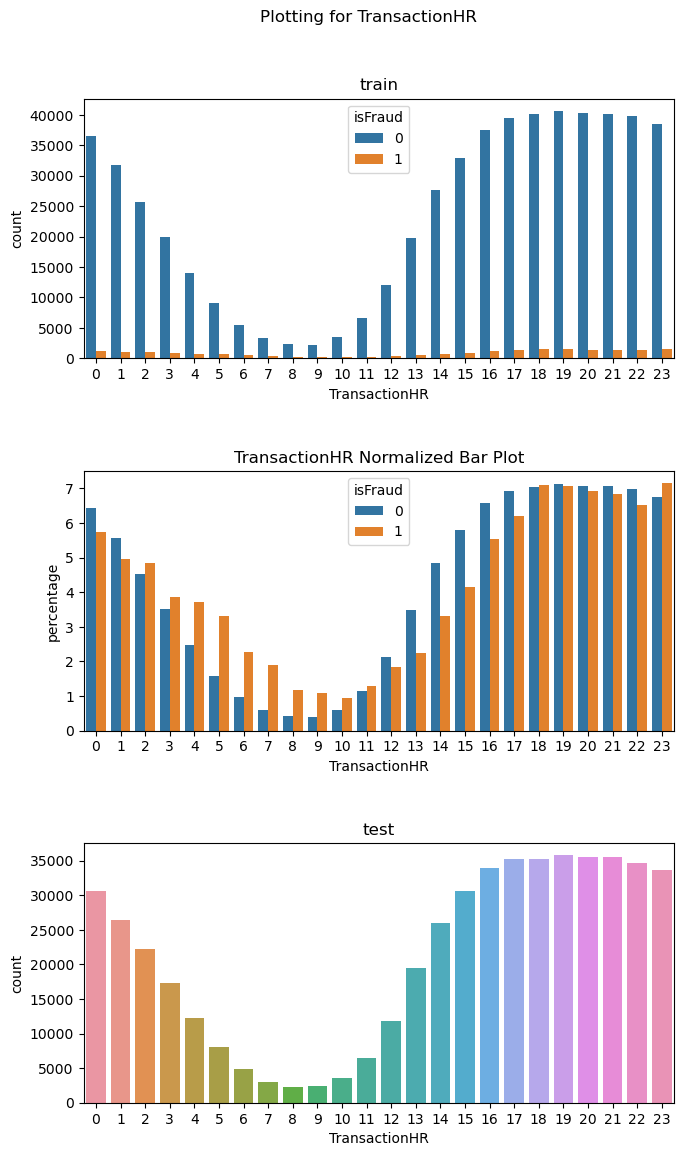

In [99]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for TransactionHR", y=1)

ax[0].set_title('train')
sns.countplot(x='TransactionHR', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("TransactionHR Normalized Bar Plot")
sns.barplot(x="TransactionHR", y="percentage", hue="isFraud", data=normHR, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='TransactionHR', data=test_data, ax=ax[2])

plt.show()

## Transaction Minutes

In [64]:
train_data['TransactionMT'] = (train_data['TransactionDateTime'].dt.minute)
test_data['TransactionMT'] = (test_data['TransactionDateTime'].dt.minute)

In [100]:
normMT = (train_data.groupby(['isFraud'])['TransactionMT']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

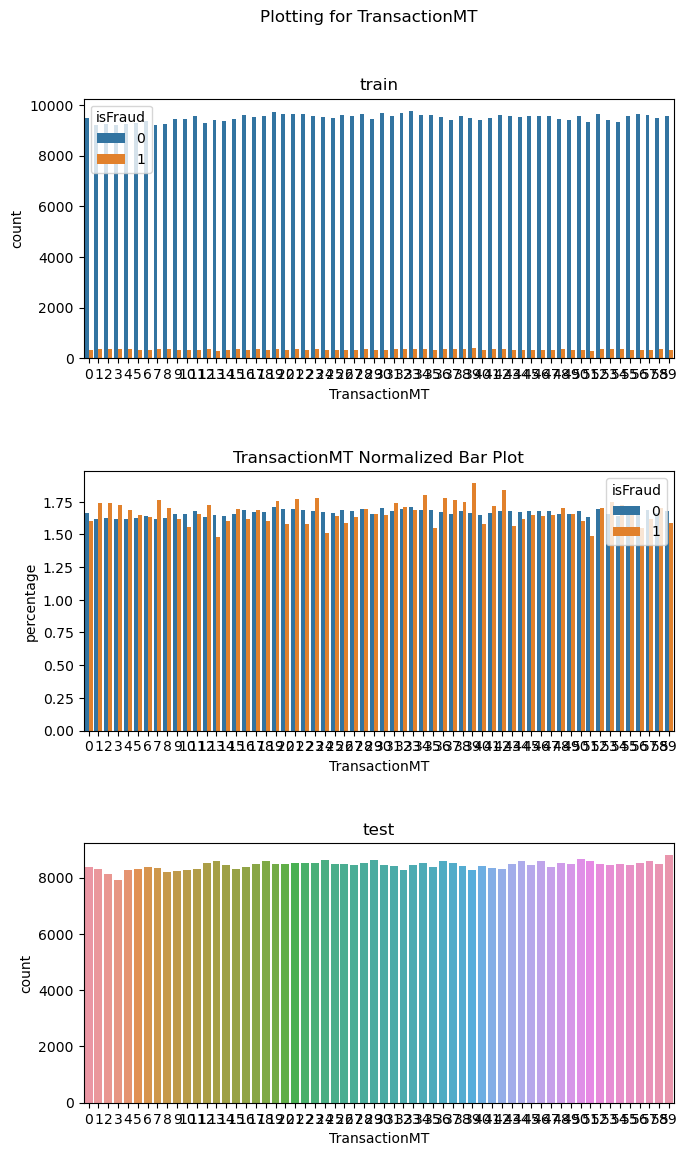

In [102]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for TransactionMT", y=1)

ax[0].set_title('train')
sns.countplot(x='TransactionMT', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("TransactionMT Normalized Bar Plot")
sns.barplot(x="TransactionMT", y="percentage", hue="isFraud", data=normMT, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='TransactionMT', data=test_data, ax=ax[2])

plt.show()

Doesn't really matter

## Transaction Day of Week

In [94]:
train_data['TransactionDW'] = (train_data['TransactionDT']//(24*3600)+ 4)%7
test_data['TransactionDW'] = (test_data['TransactionDT']//(24*3600)+ 4)%7

# to make monday = 0, and sunday = 6

In [80]:
train_data['day_week'] = train_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x))).dt.day_name()
test_data['day_week'] = test_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x))).dt.day_name()

In [97]:
train_data[['TransactionDateTime', 'TransactionHR', 'TransactionMT', 'TransactionDW', 'day_week']].head()

,TransactionDateTime,TransactionHR,TransactionMT,TransactionDW,day_week
TransactionID,,,,,
2987000,2017-12-02 00:00:00,0,0,5,Saturday
2987001,2017-12-02 00:00:01,0,0,5,Saturday
2987002,2017-12-02 00:01:09,0,1,5,Saturday
2987003,2017-12-02 00:01:39,0,1,5,Saturday
2987004,2017-12-02 00:01:46,0,1,5,Saturday


In [105]:
normDW = (train_data.groupby(['isFraud'])['TransactionDW']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

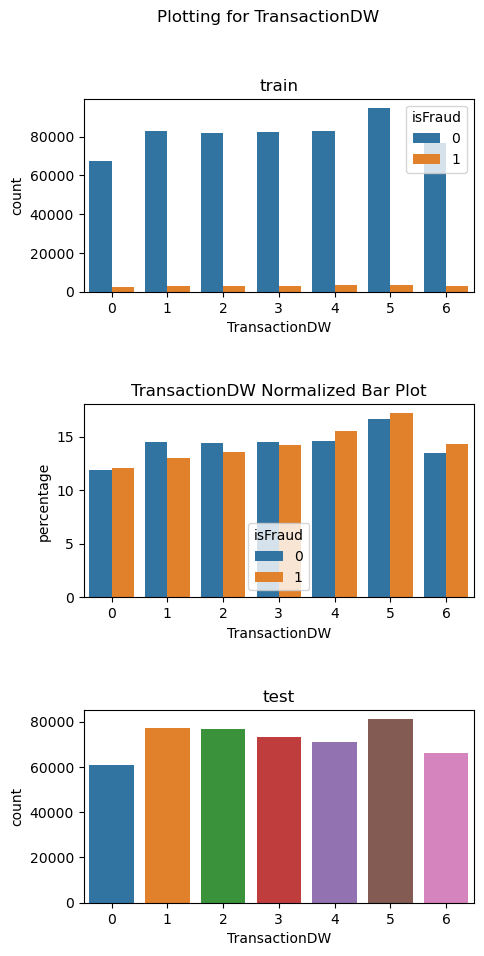

In [106]:
fig, ax = plt.subplots(3,1, figsize=(6,10))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for TransactionDW", y=1)

ax[0].set_title('train')
sns.countplot(x='TransactionDW', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("TransactionDW Normalized Bar Plot")
sns.barplot(x="TransactionDW", y="percentage", hue="isFraud", data=normDW, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='TransactionDW', data=test_data, ax=ax[2])

plt.show()

Doesn't really tell anything?

In [127]:
train_data.drop(['day_week', 'TransactionDateTime'], axis=1, inplace=True)

In [107]:
train_data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_35,id_36,id_37,DeviceType,DeviceInfo,TransactionDateTime,TransactionHR,TransactionMT,TransactionDW,day_week
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:00,0,0,5,Saturday
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:00:01,0,0,5,Saturday
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:01:09,0,1,5,Saturday
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,2017-12-02 00:01:39,0,1,5,Saturday
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,T,F,T,mobile,SAMSUNG SM-G892A Build/NRD90M,2017-12-02 00:01:46,0,1,5,Saturday


## Dollar & Cents Separation

In [122]:
train_data['TransactionAmt'].iloc[:1]

TransactionID
2987000    68.5
Name: TransactionAmt, dtype: float64

In [124]:
train_dollar = [int(str(a).split('.')[0]) for a in train_data['TransactionAmt'].values]
train_cents = [int(str(a).split('.')[1]) for a in train_data['TransactionAmt'].values]

test_dollar = [int(str(a).split('.')[0]) for a in test_data['TransactionAmt'].values]
test_cents = [int(str(a).split('.')[1]) for a in test_data['TransactionAmt'].values]

In [125]:
train_data['dollars'] = train_dollar
train_data['cents'] = train_cents

test_data['dollars'] = test_dollar
test_data['cents'] = test_cents

In [134]:
train_data.shape

(590540, 164)

## Card 1

In [144]:
train_data['card1'].head()

TransactionID
2987000    13926
2987001     2755
2987002     4663
2987003    18132
2987004     4497
Name: card1, dtype: int64

In [139]:
train_data['card1_div_1000'] = train_data['card1']//1000
test_data['card1_div_1000'] = test_data['card1']//1000

In [140]:
norm_card1_div_1000 = (train_data.groupby(['isFraud'])['card1_div_1000']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

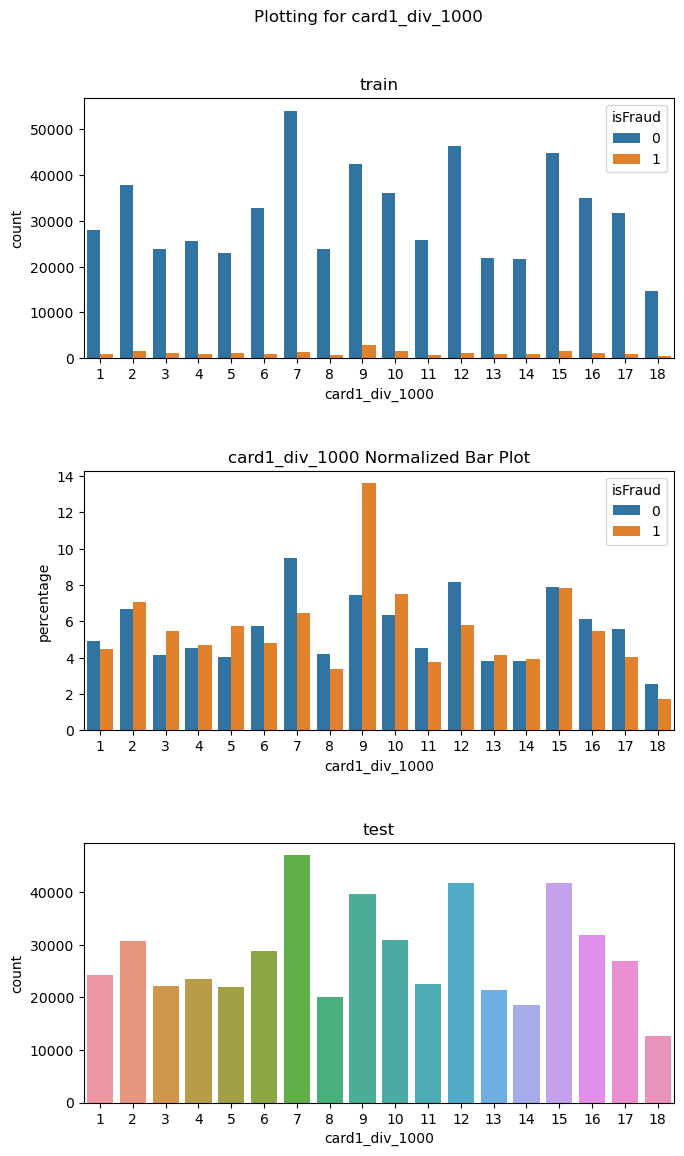

In [141]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for card1_div_1000", y=1)

ax[0].set_title('train')
sns.countplot(x='card1_div_1000', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("card1_div_1000 Normalized Bar Plot")
sns.barplot(x="card1_div_1000", y="percentage", hue="isFraud", data=norm_card1_div_1000, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='card1_div_1000', data=test_data, ax=ax[2])

plt.show()

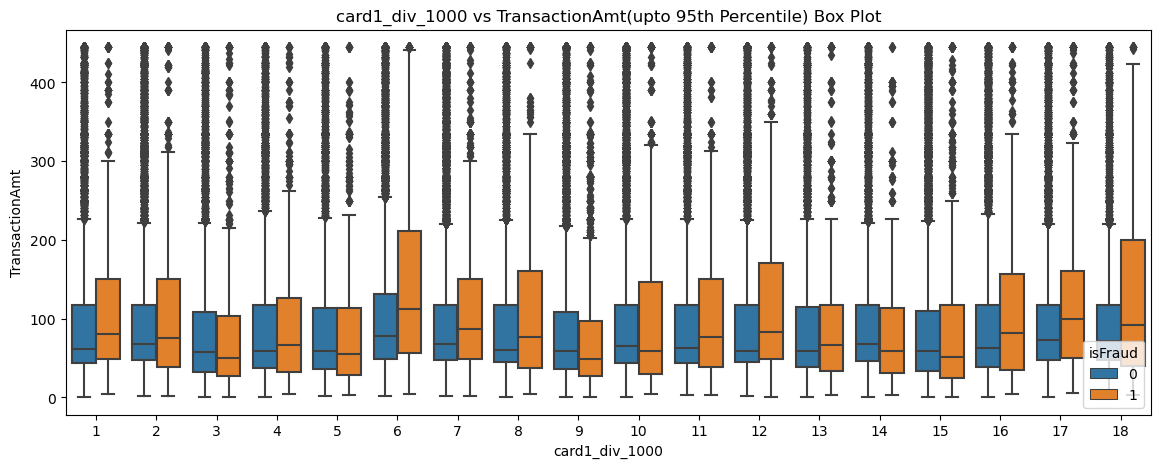

In [142]:
plt.figure(figsize=(14,5))
sns.boxplot(x='card1_div_1000', y='TransactionAmt', hue='isFraud', data=train_data[train_data['TransactionAmt']<=np.percentile(train_data['TransactionAmt'], 95)])
plt.title('card1_div_1000 vs TransactionAmt(upto 95th Percentile) Box Plot')
plt.show()

## Card2

In [143]:
train_data['card2'].head()

TransactionID
2987000      NaN
2987001    404.0
2987002    490.0
2987003    567.0
2987004    514.0
Name: card2, dtype: float64

In [145]:
train_data['card2_div_10'] = train_data['card2']//10
test_data['card2_div_10'] = test_data['card2']//10

In [146]:
norm_card2_div_10 = (train_data.groupby(['isFraud'])['card2_div_10']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

## Email Domain

In [147]:
norm_card2_div_10.head()

,isFraud,card2_div_10,percentage
0,0,32.0,9.612072
28,0,12.0,0.796271
29,0,44.0,0.760999
30,0,27.0,0.687785
31,0,53.0,0.646280


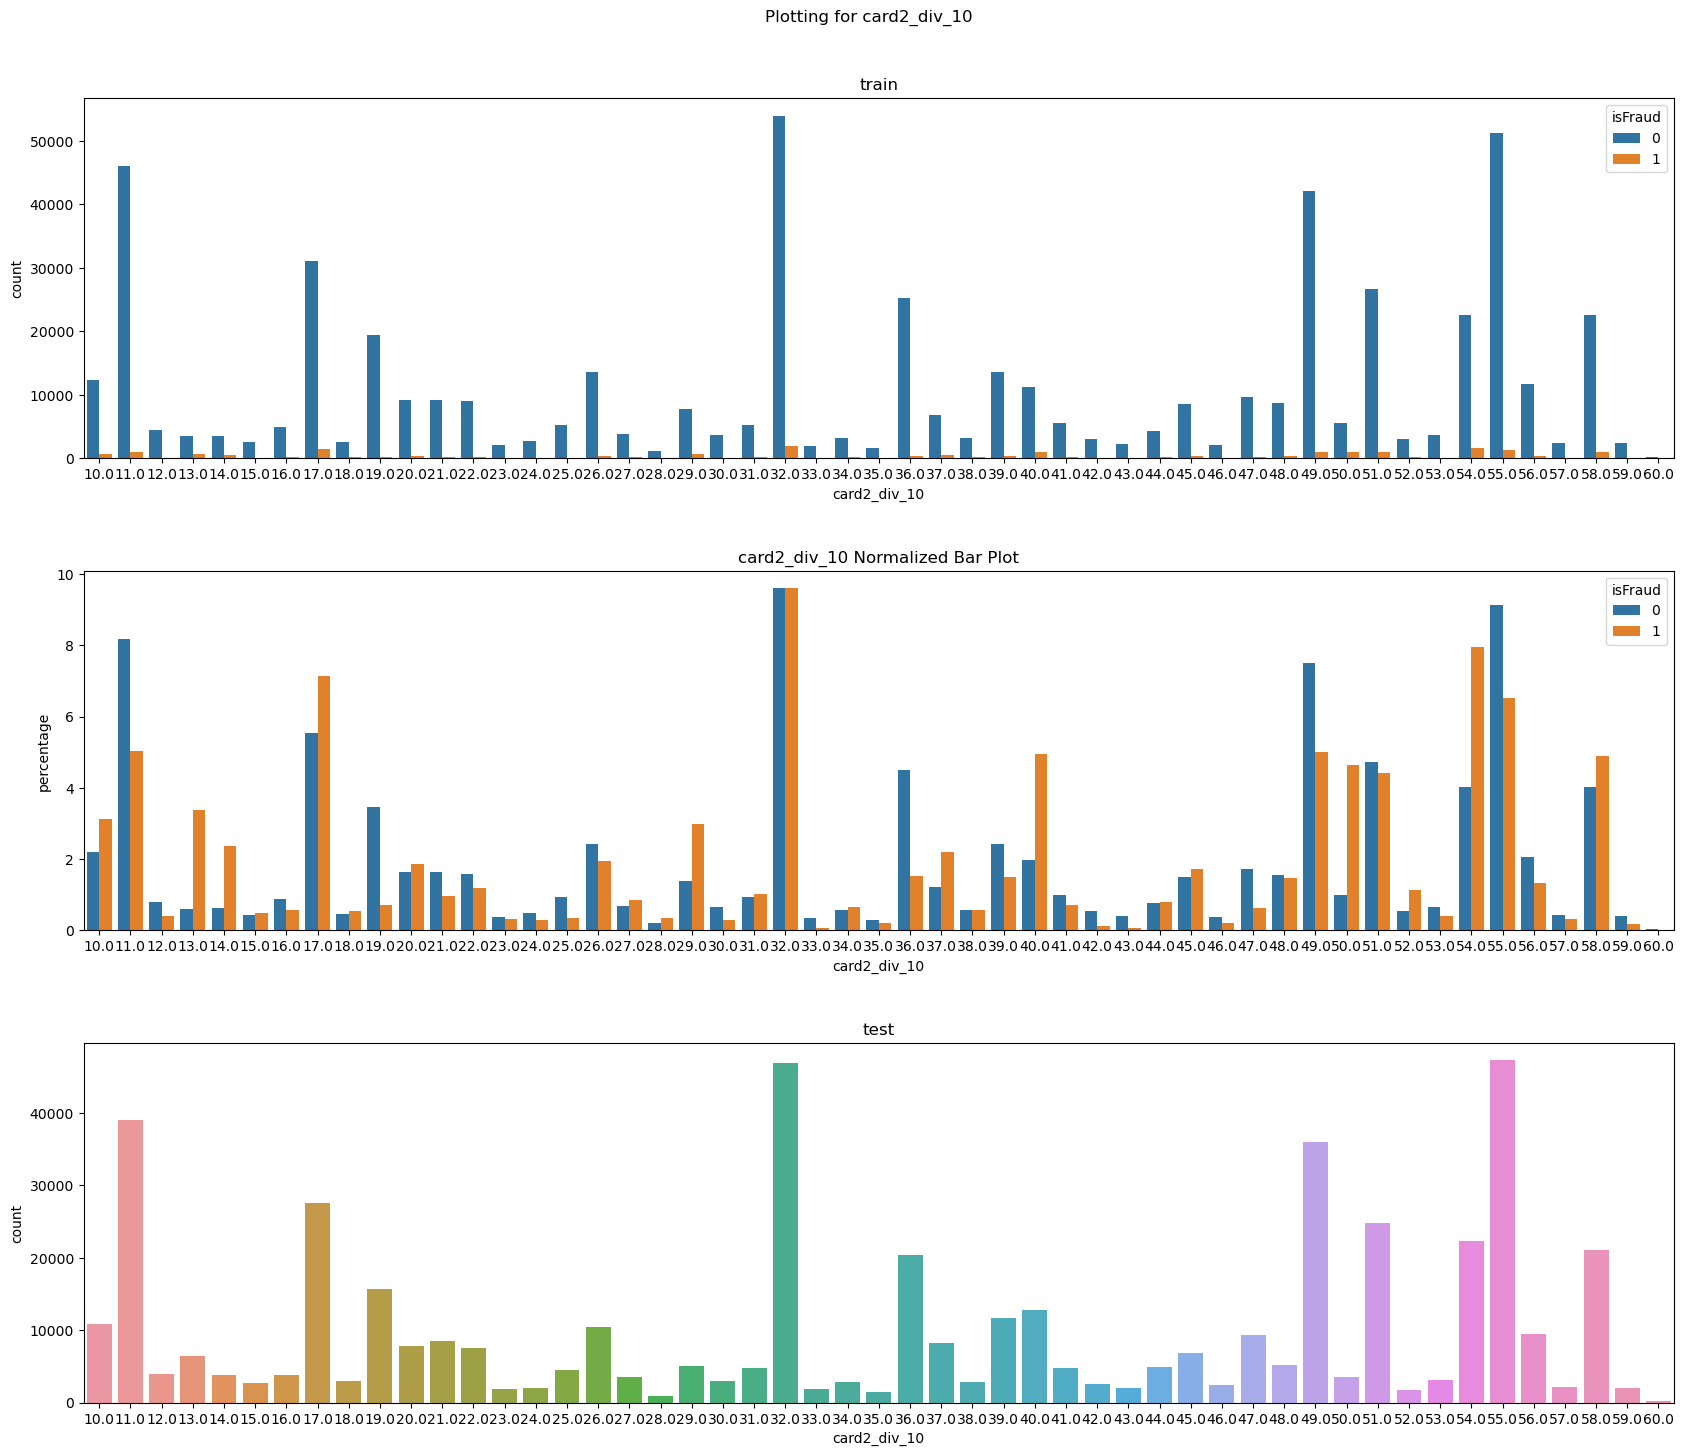

In [148]:
fig, ax = plt.subplots(3,1, figsize=(18,15))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for card2_div_10", y=1)

ax[0].set_title('train')
sns.countplot(x='card2_div_10', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="card2_div_10", y="percentage", hue="isFraud", data=norm_card2_div_10, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='card2_div_10', data=test_data, ax=ax[2])

plt.show()

In [150]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499

parent_domain = {'gmail.com':'google', 'outlook.com':'microsoft', 
                 'yahoo.com':'yahoo', 'mail.com':'mail', 'anonymous.com':'anonymous', 
                 'hotmail.com':'microsoft', 'verizon.net':'verizon', 'aol.com':'aol', 
                 'me.com':'apple', 'comcast.net':'comcast', 'optonline.net':'optimum', 
                 'cox.net':'cox', 'charter.net':'spectrum', 'rocketmail.com':'yahoo', 
                 'prodigy.net.mx':'AT&T', 'embarqmail.com':'century_link', 'icloud.com':'apple', 
                 'live.com.mx':'microsoft', 'gmail':'gmail', 'live.com':'microsoft', 
                 'att.net':'AT&T', 'juno.com':'juno', 'ymail.com':'yahoo', 
                 'sbcglobal.net':'sbcglobal', 'bellsouth.net':'AT&T', 'msn.com':'microsoft', 
                 'q.com':'century_link','yahoo.com.mx':'yahoo', 'centurylink.net':'century_link',  
                 'servicios-ta.com':'asur','earthlink.net':'earthlink', 'hotmail.es':'microsoft', 
                 'cfl.rr.com':'spectrum', 'roadrunner.com':'spectrum','netzero.net':'netzero', 
                 'gmx.de':'gmx','suddenlink.net':'suddenlink','frontiernet.net':'frontier', 
                 'windstream.net':'windstream','frontier.com':'frontier','outlook.es':'microsoft', 
                 'mac.com':'apple','netzero.com':'netzero','aim.com':'aol', 
                 'web.de':'web_de','twc.com':'whois','cableone.net':'sparklight', 
                 'yahoo.fr':'yahoo','yahoo.de':'yahoo','yahoo.es':'yahoo', 'scranton.edu':'scranton', 
                 'sc.rr.com':'sc_rr','ptd.net':'ptd','live.fr':'microsoft', 
                 'yahoo.co.uk':'yahoo','hotmail.fr':'microsoft','hotmail.de':'microsoft', 
                 'hotmail.co.uk':'microsoft','protonmail.com':'protonmail','yahoo.co.jp':'yahoo'}

In [151]:
train_P_emaildomain = train_data['P_emaildomain']
test_P_emaildomain = test_data['P_emaildomain']

train_data['P_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in train_P_emaildomain] 
test_data['P_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in test_P_emaildomain]

train_data['P_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in train_P_emaildomain]
test_data['P_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in test_P_emaildomain]

train_data['P_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in train_P_emaildomain]
test_data['P_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in test_P_emaildomain]

In [152]:
train_data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C9,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V18,V20,V30,V36,V37,V40,V44,V47,V48,V52,V54,V60,V70,V76,V78,V80,V81,V82,V87,V91,V99,V127,V130,V131,V139,V147,V156,V165,V166,V169,V171,V173,V174,V175,V176,V180,V183,V185,V195,V198,V203,V205,V207,V209,V210,V215,V216,V220,V221,V223,V230,V234,V235,V238,V240,V241,V250,V252,V257,V258,V260,V262,V263,V264,V265,V268,V271,V274,V277,V282,V283,V289,V291,V303,V307,V310,V312,V315,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,TransactionHR,TransactionMT,TransactionDW,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,117.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5,68,5,NaN,NaN,NaN,13,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5,29,0,google,gmail,com,2,40.0
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5,59,0,microsoft,outlook,com,4,49.0
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,10.0,1758.0,354.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1758.0,354.0,135.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5,50,0,yahoo,yahoo,com,18,56.0
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.co

In [137]:
norm_P_parent_domain = (train_data.groupby(['isFraud'])['P_parent_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

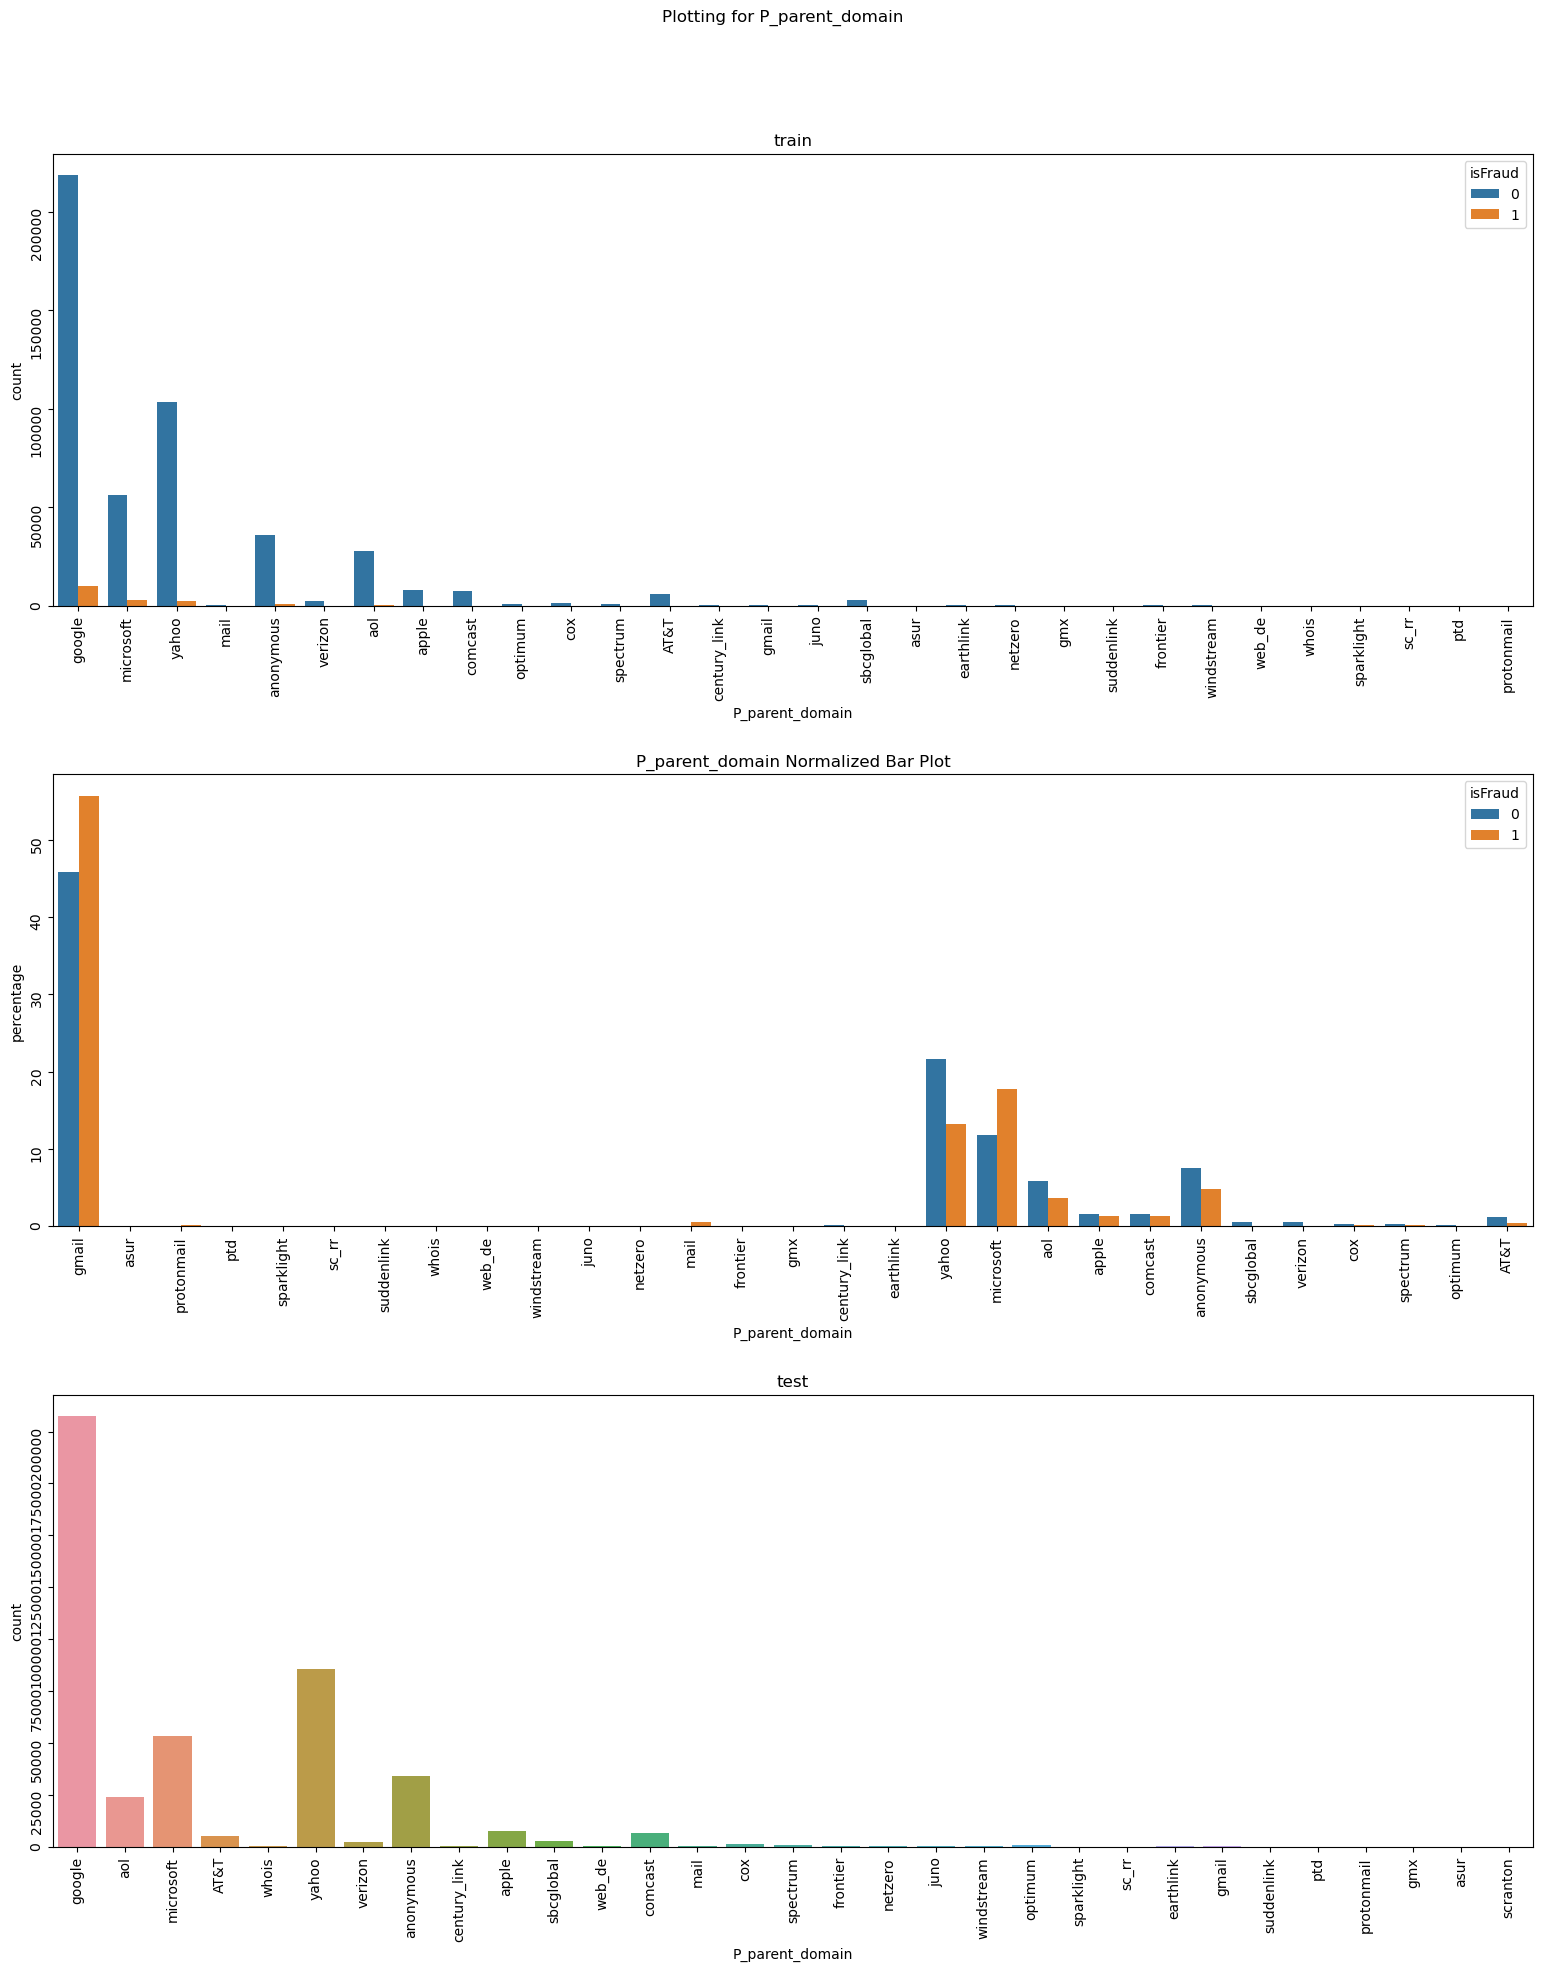

In [154]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_parent_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='P_parent_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("P_parent_domain Normalized Bar Plot")
sns.barplot(x="P_parent_domain", y="percentage", hue="isFraud", data=norm_P_parent_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_parent_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [155]:
norm_P_domain_name = (train_data.groupby(['isFraud'])['P_domain_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

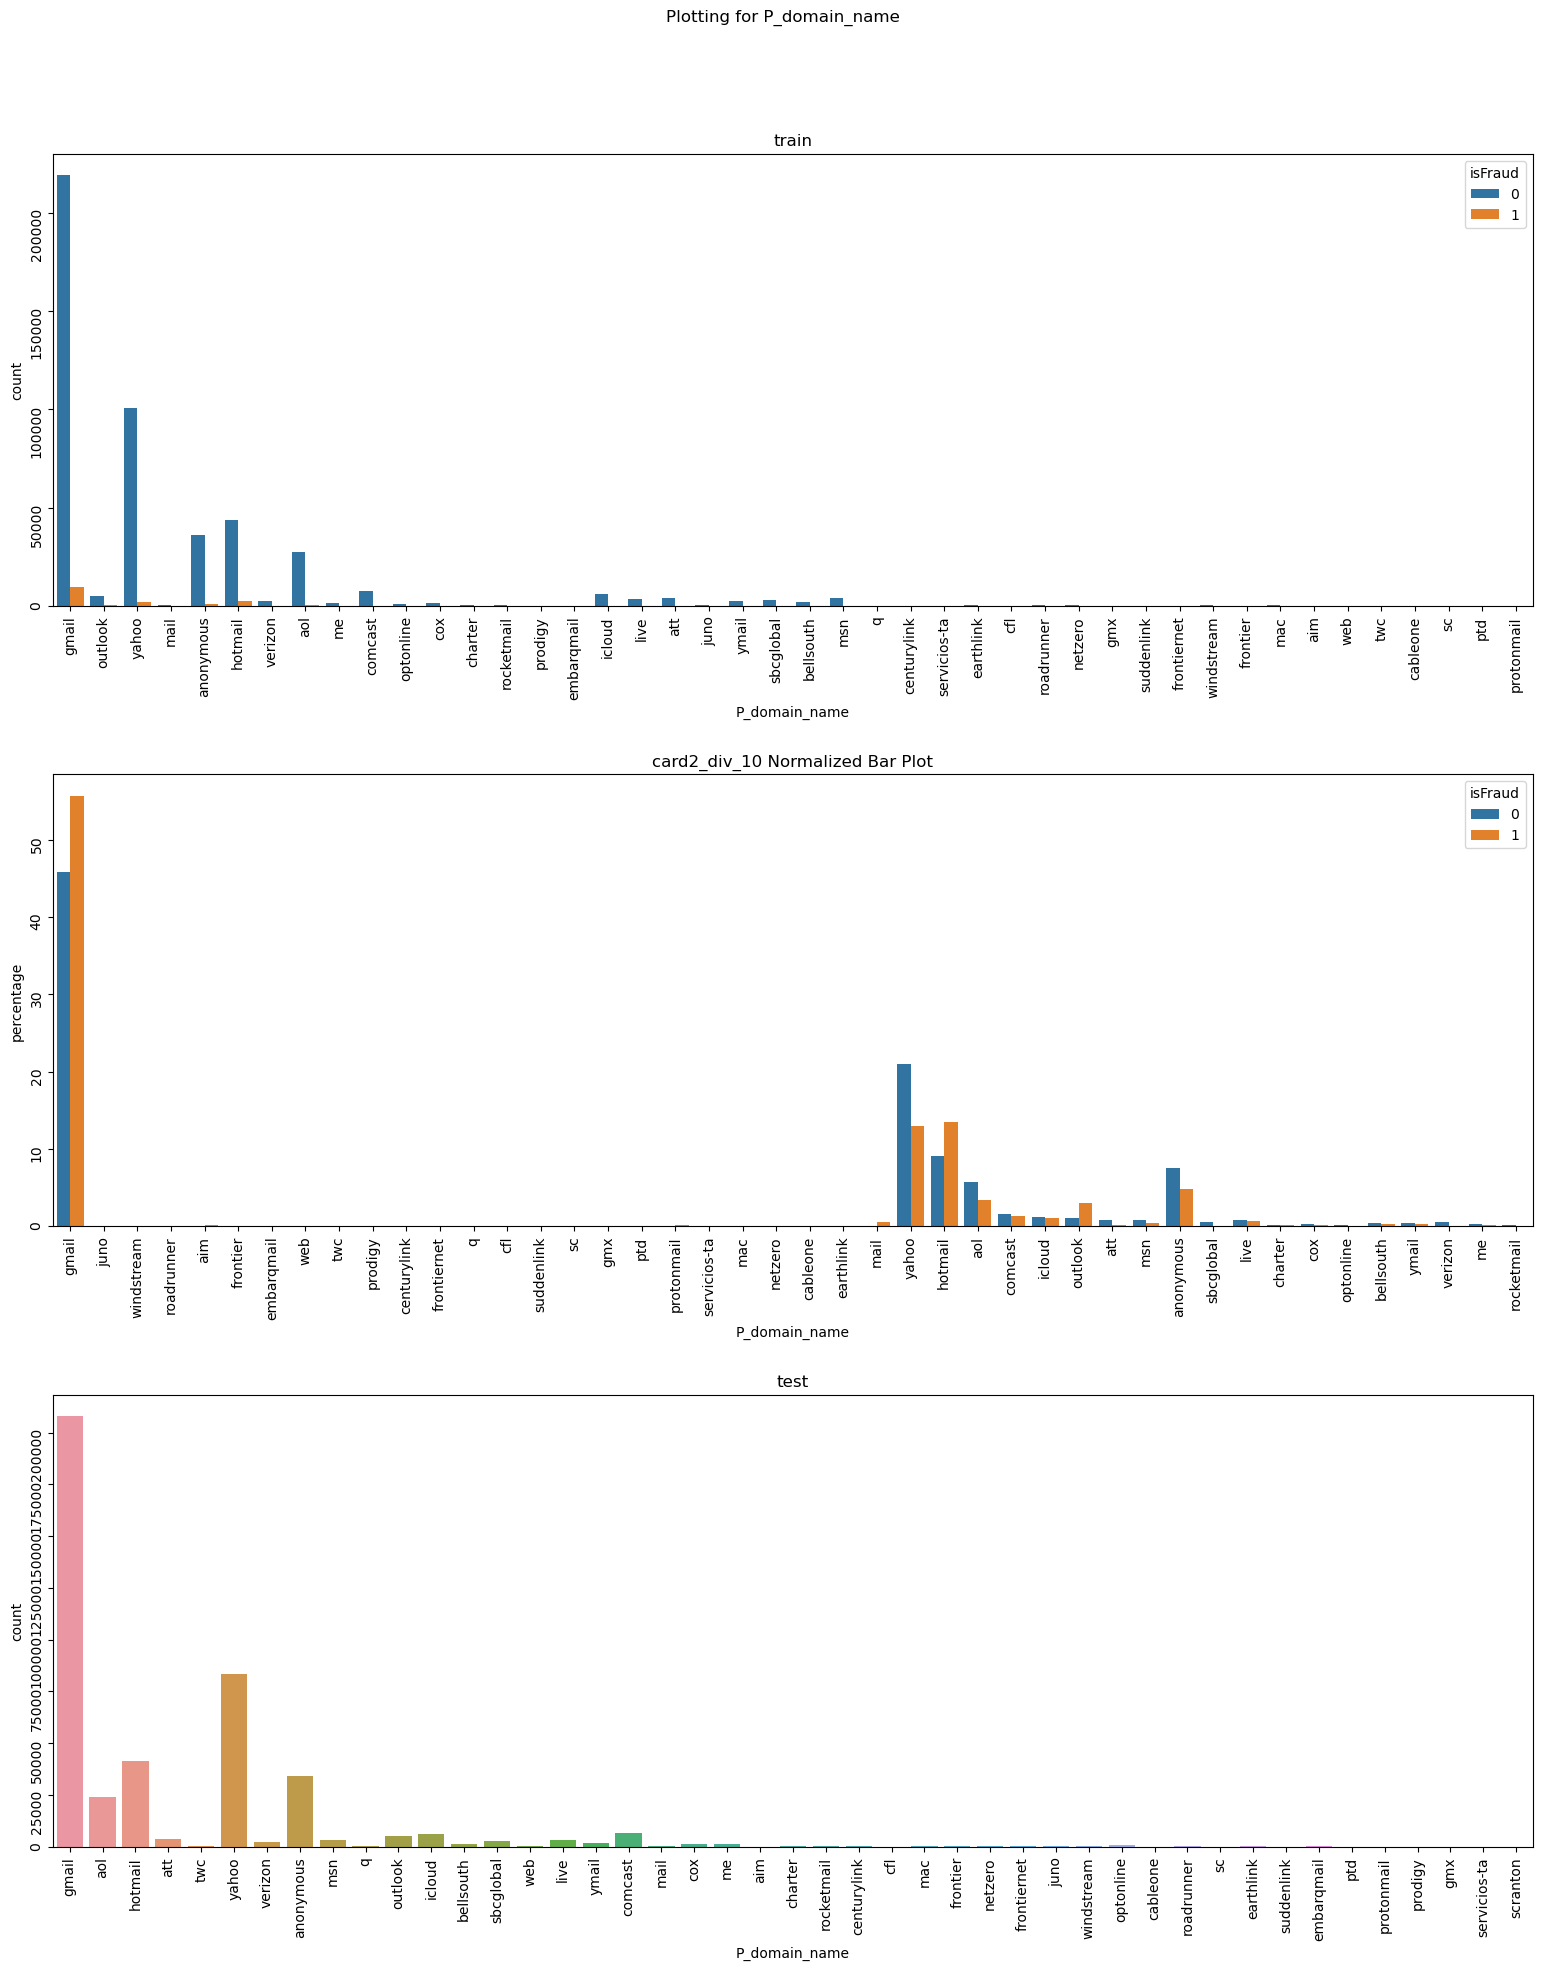

In [156]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_domain_name", y=1)

ax[0].set_title('train')
sns.countplot(x='P_domain_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="P_domain_name", y="percentage", hue="isFraud", data=norm_P_domain_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_domain_name', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [157]:
norm_P_top_level_domain = (train_data.groupby(['isFraud'])['P_top_level_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

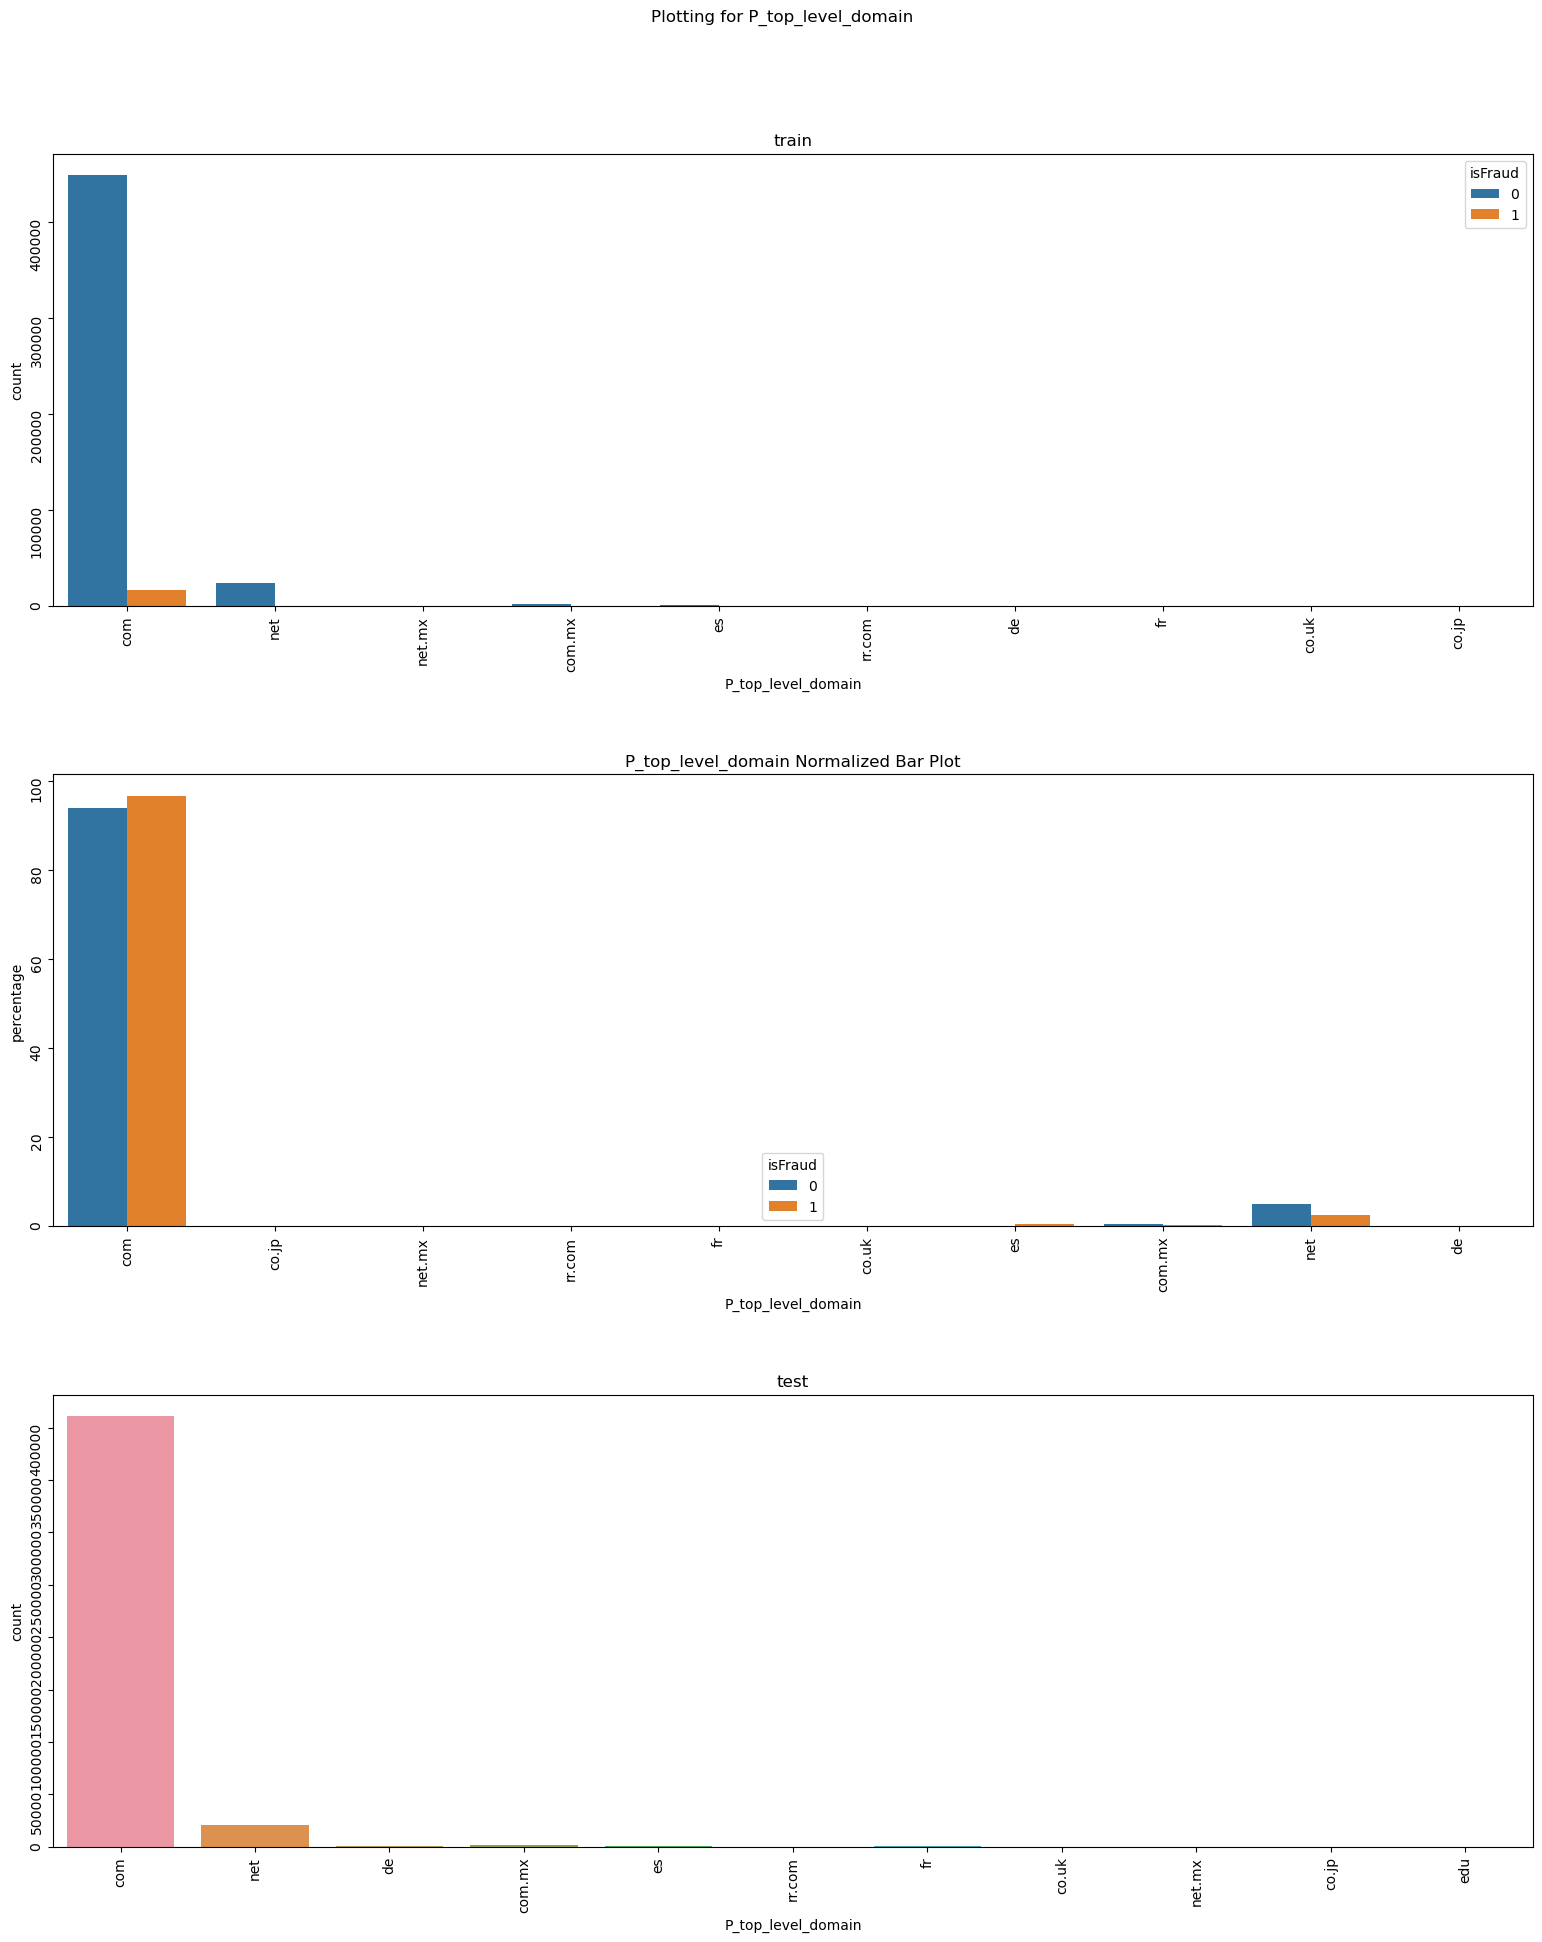

In [158]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_top_level_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='P_top_level_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("P_top_level_domain Normalized Bar Plot")
sns.barplot(x="P_top_level_domain", y="percentage", hue="isFraud", data=norm_P_top_level_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_top_level_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [159]:
train_R_emaildomain = train_data['R_emaildomain']
test_R_emaildomain = test_data['R_emaildomain']

train_data['R_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in train_R_emaildomain] 
test_data['R_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in test_R_emaildomain]

train_data['R_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in train_R_emaildomain]
test_data['R_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in test_R_emaildomain]

train_data['R_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in train_R_emaildomain]
test_data['R_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in test_R_emaildomain]

In [160]:
norm_R_parent_domain = (train_data.groupby(['isFraud'])['R_parent_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

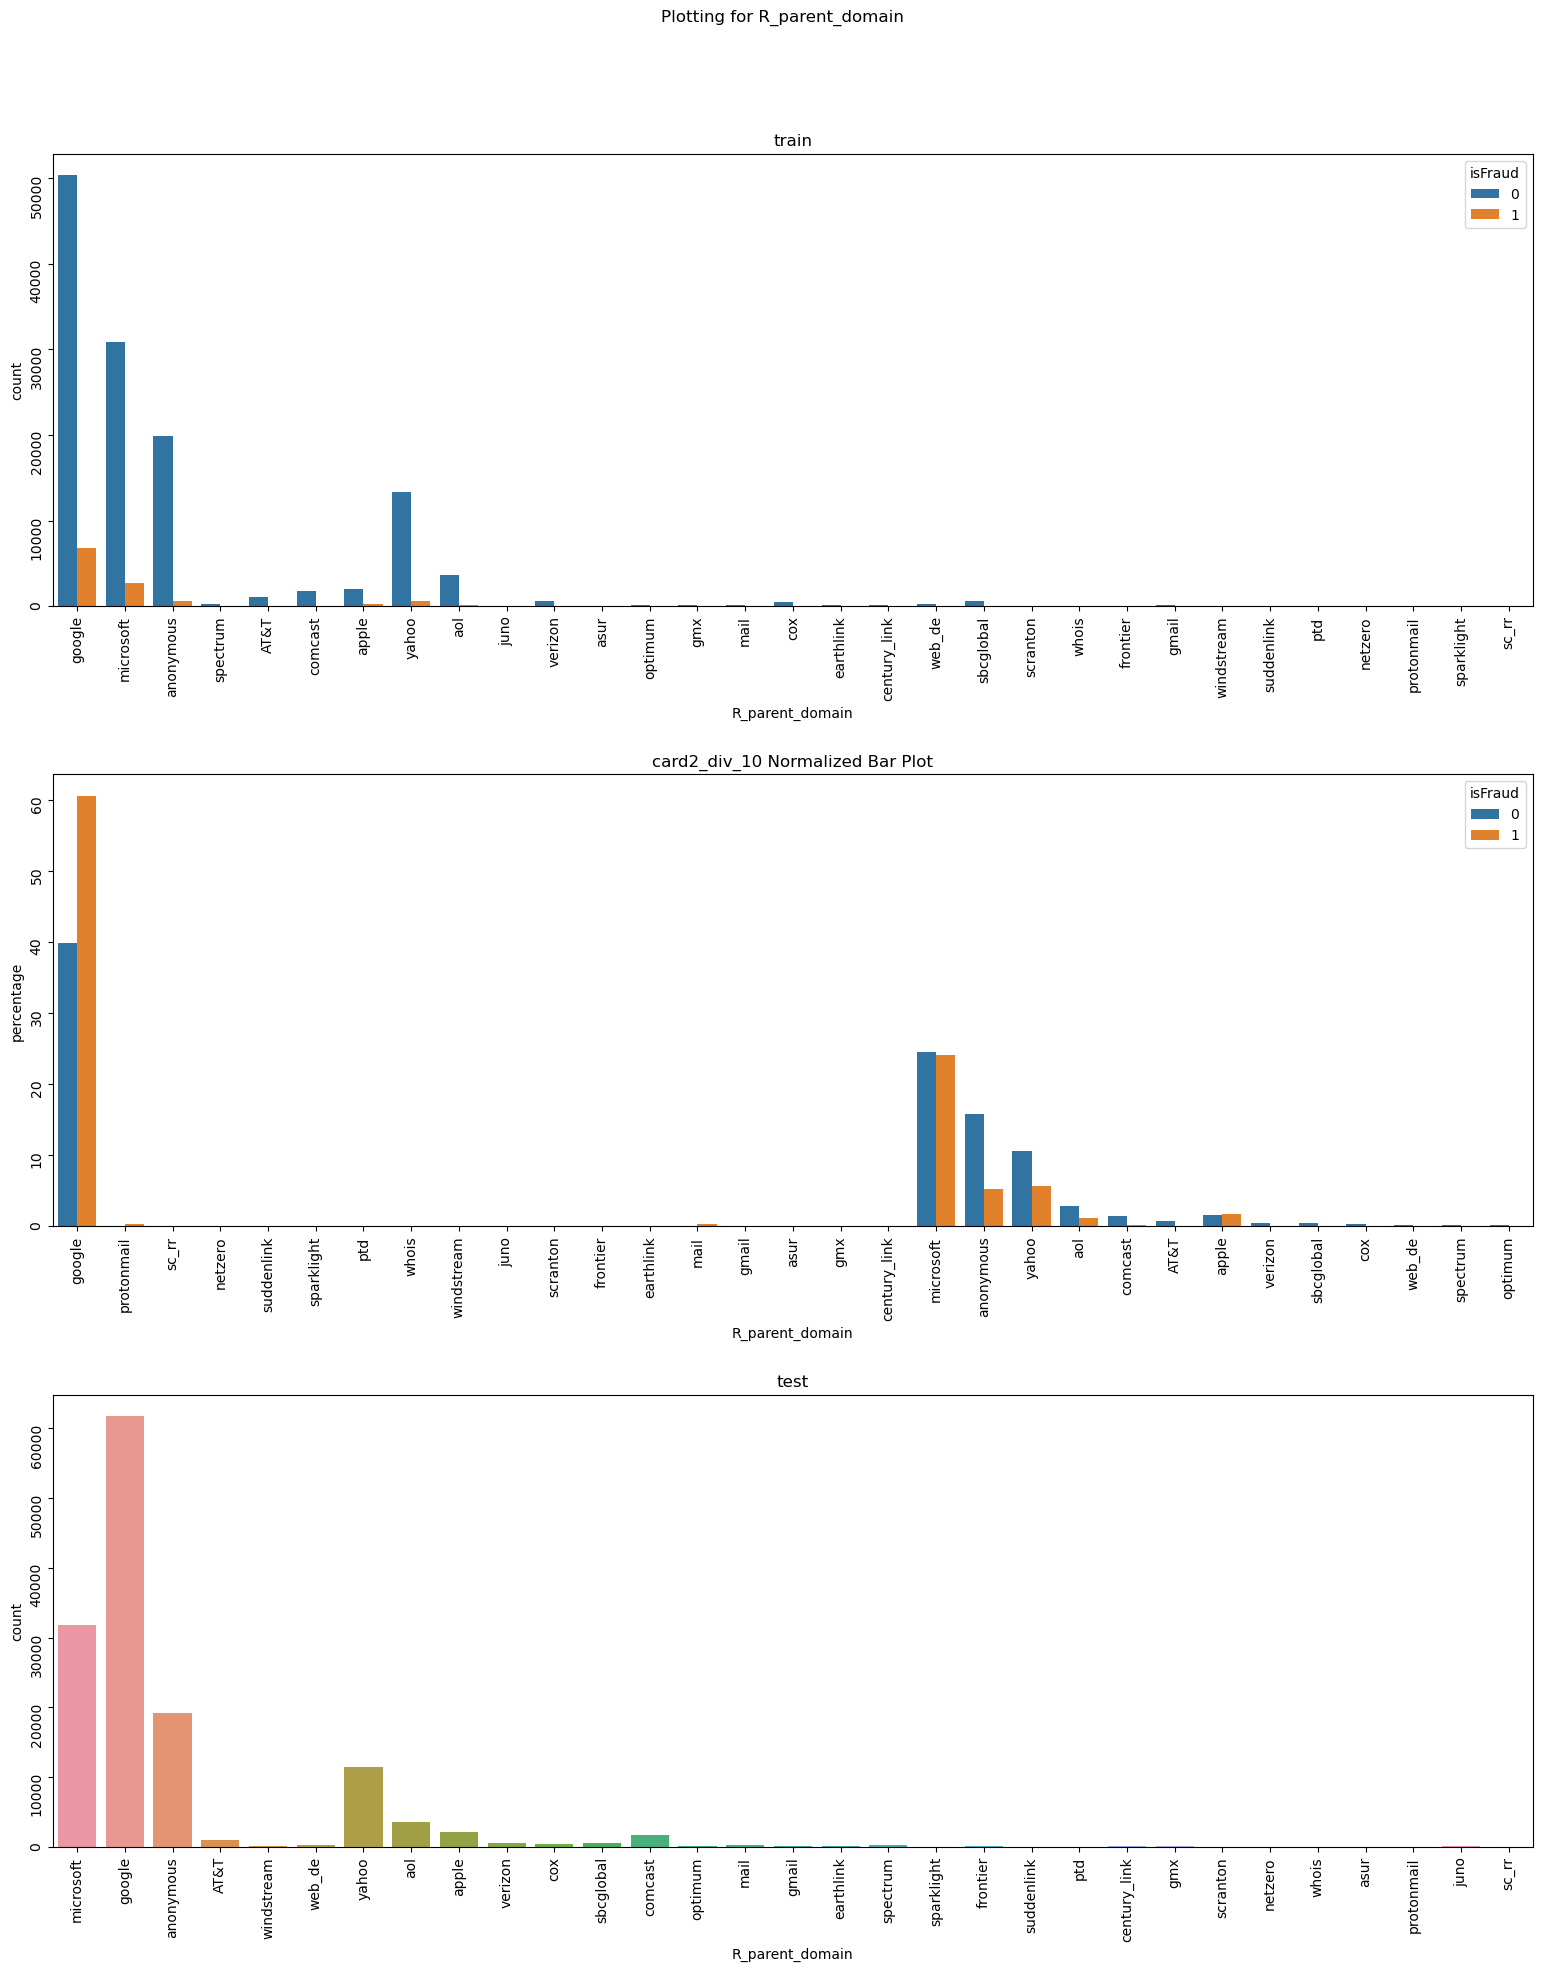

In [161]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_parent_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='R_parent_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="R_parent_domain", y="percentage", hue="isFraud", data=norm_R_parent_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_parent_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [162]:
norm_R_domain_name = (train_data.groupby(['isFraud'])['R_domain_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

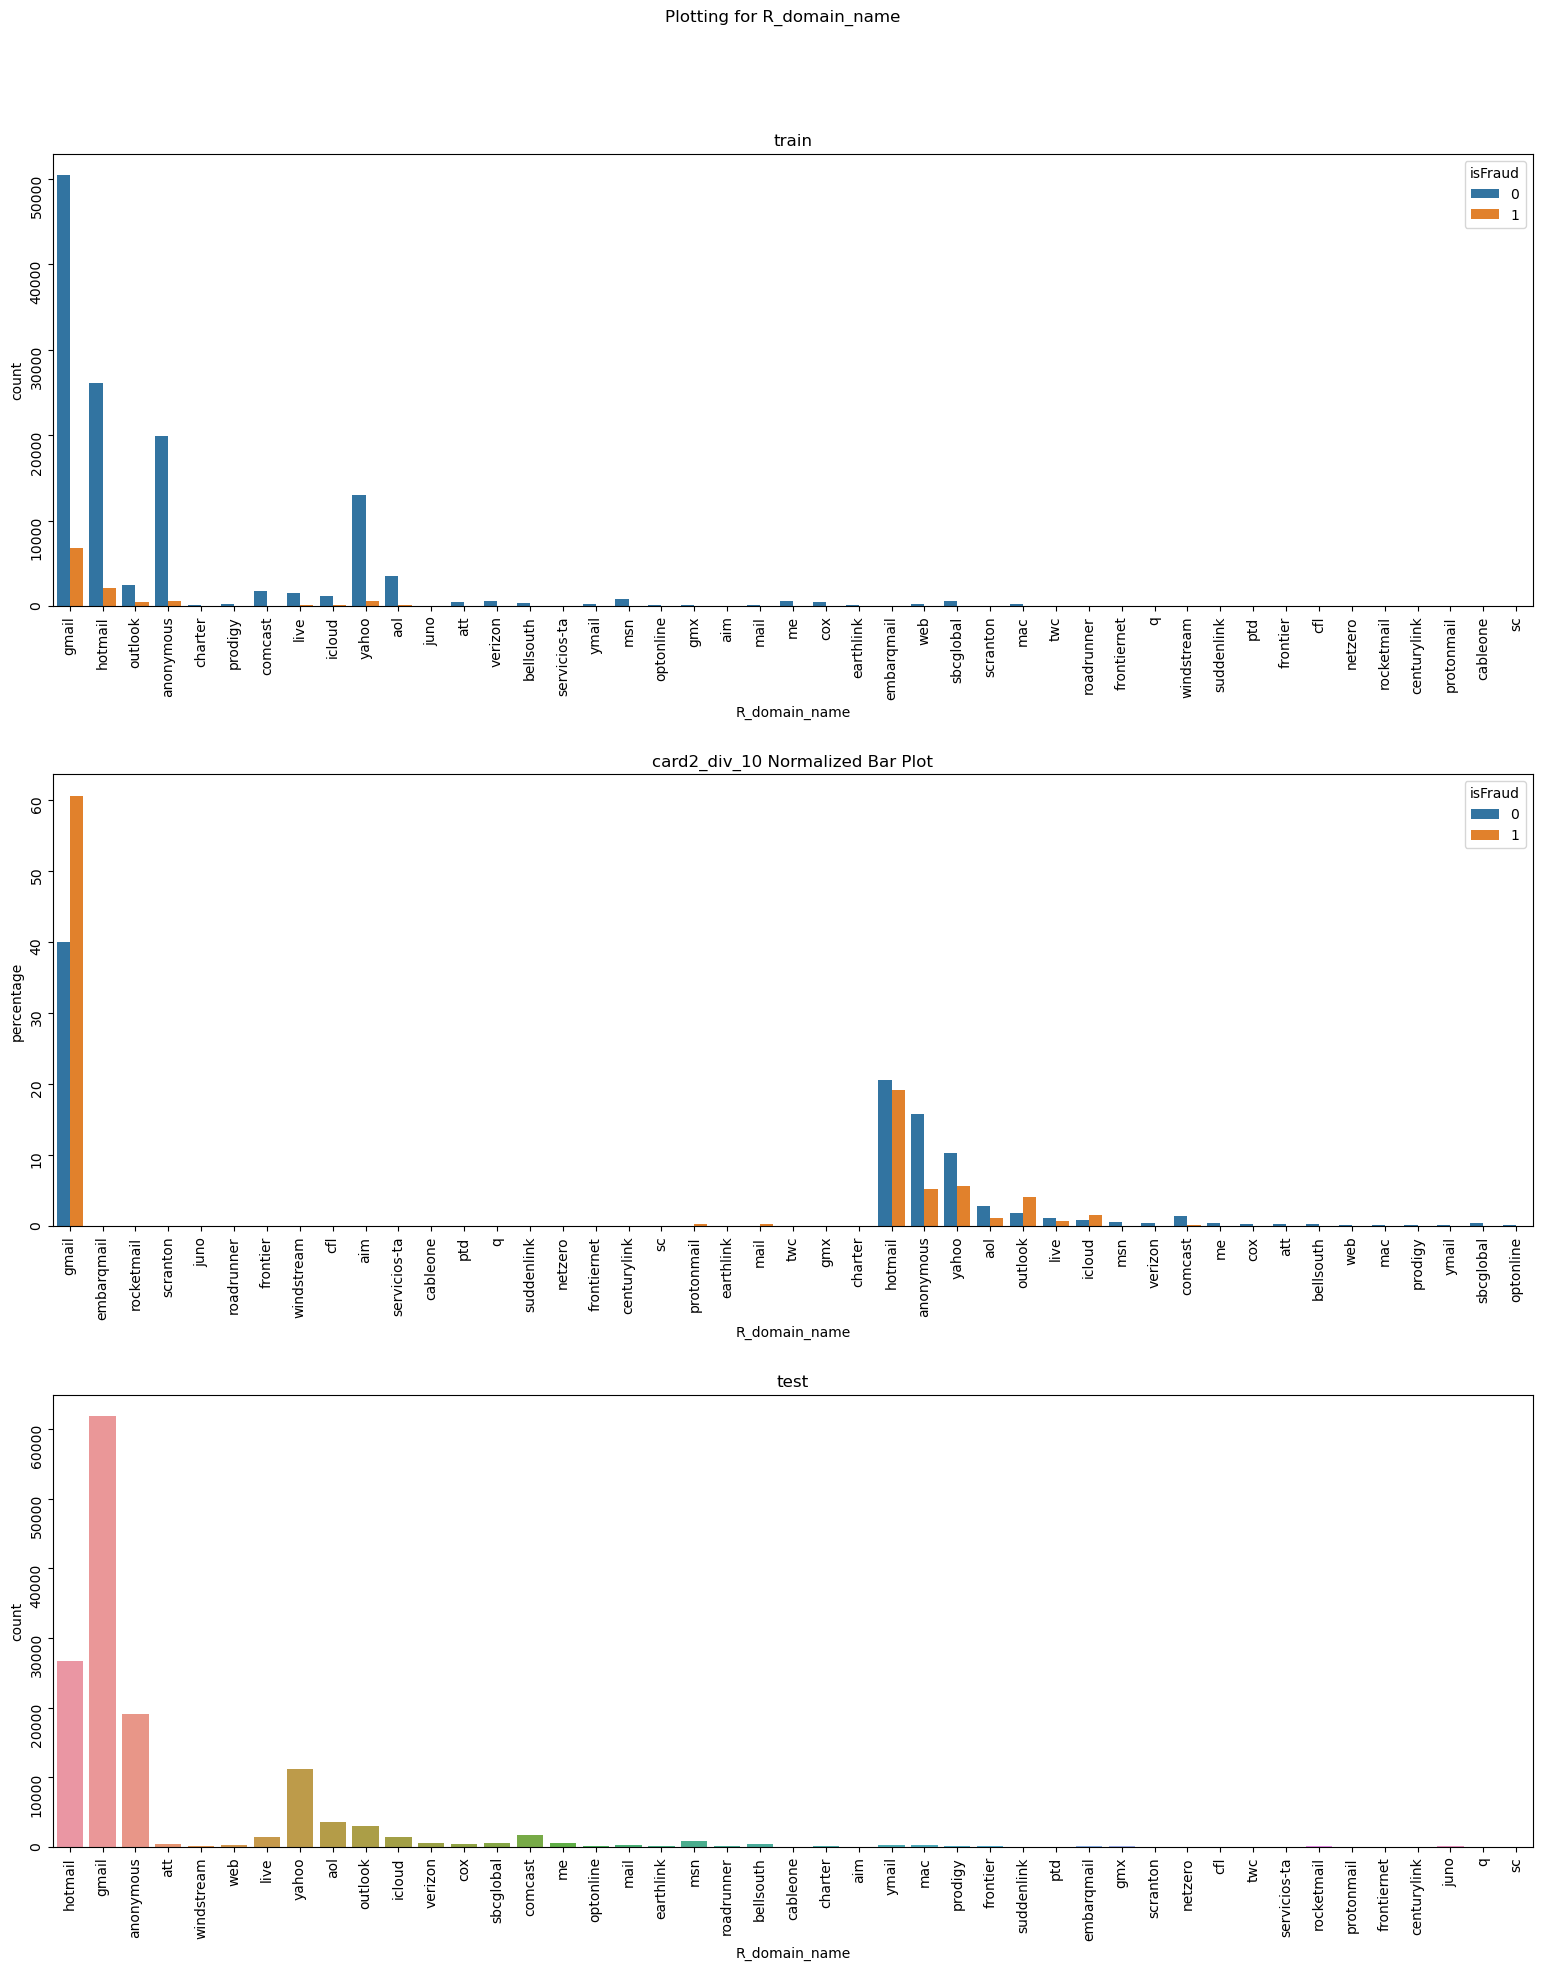

In [163]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_domain_name", y=1)

ax[0].set_title('train')
sns.countplot(x='R_domain_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="R_domain_name", y="percentage", hue="isFraud", data=norm_R_domain_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_domain_name', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [164]:
norm_R_top_level_domain = (train_data.groupby(['isFraud'])['R_top_level_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

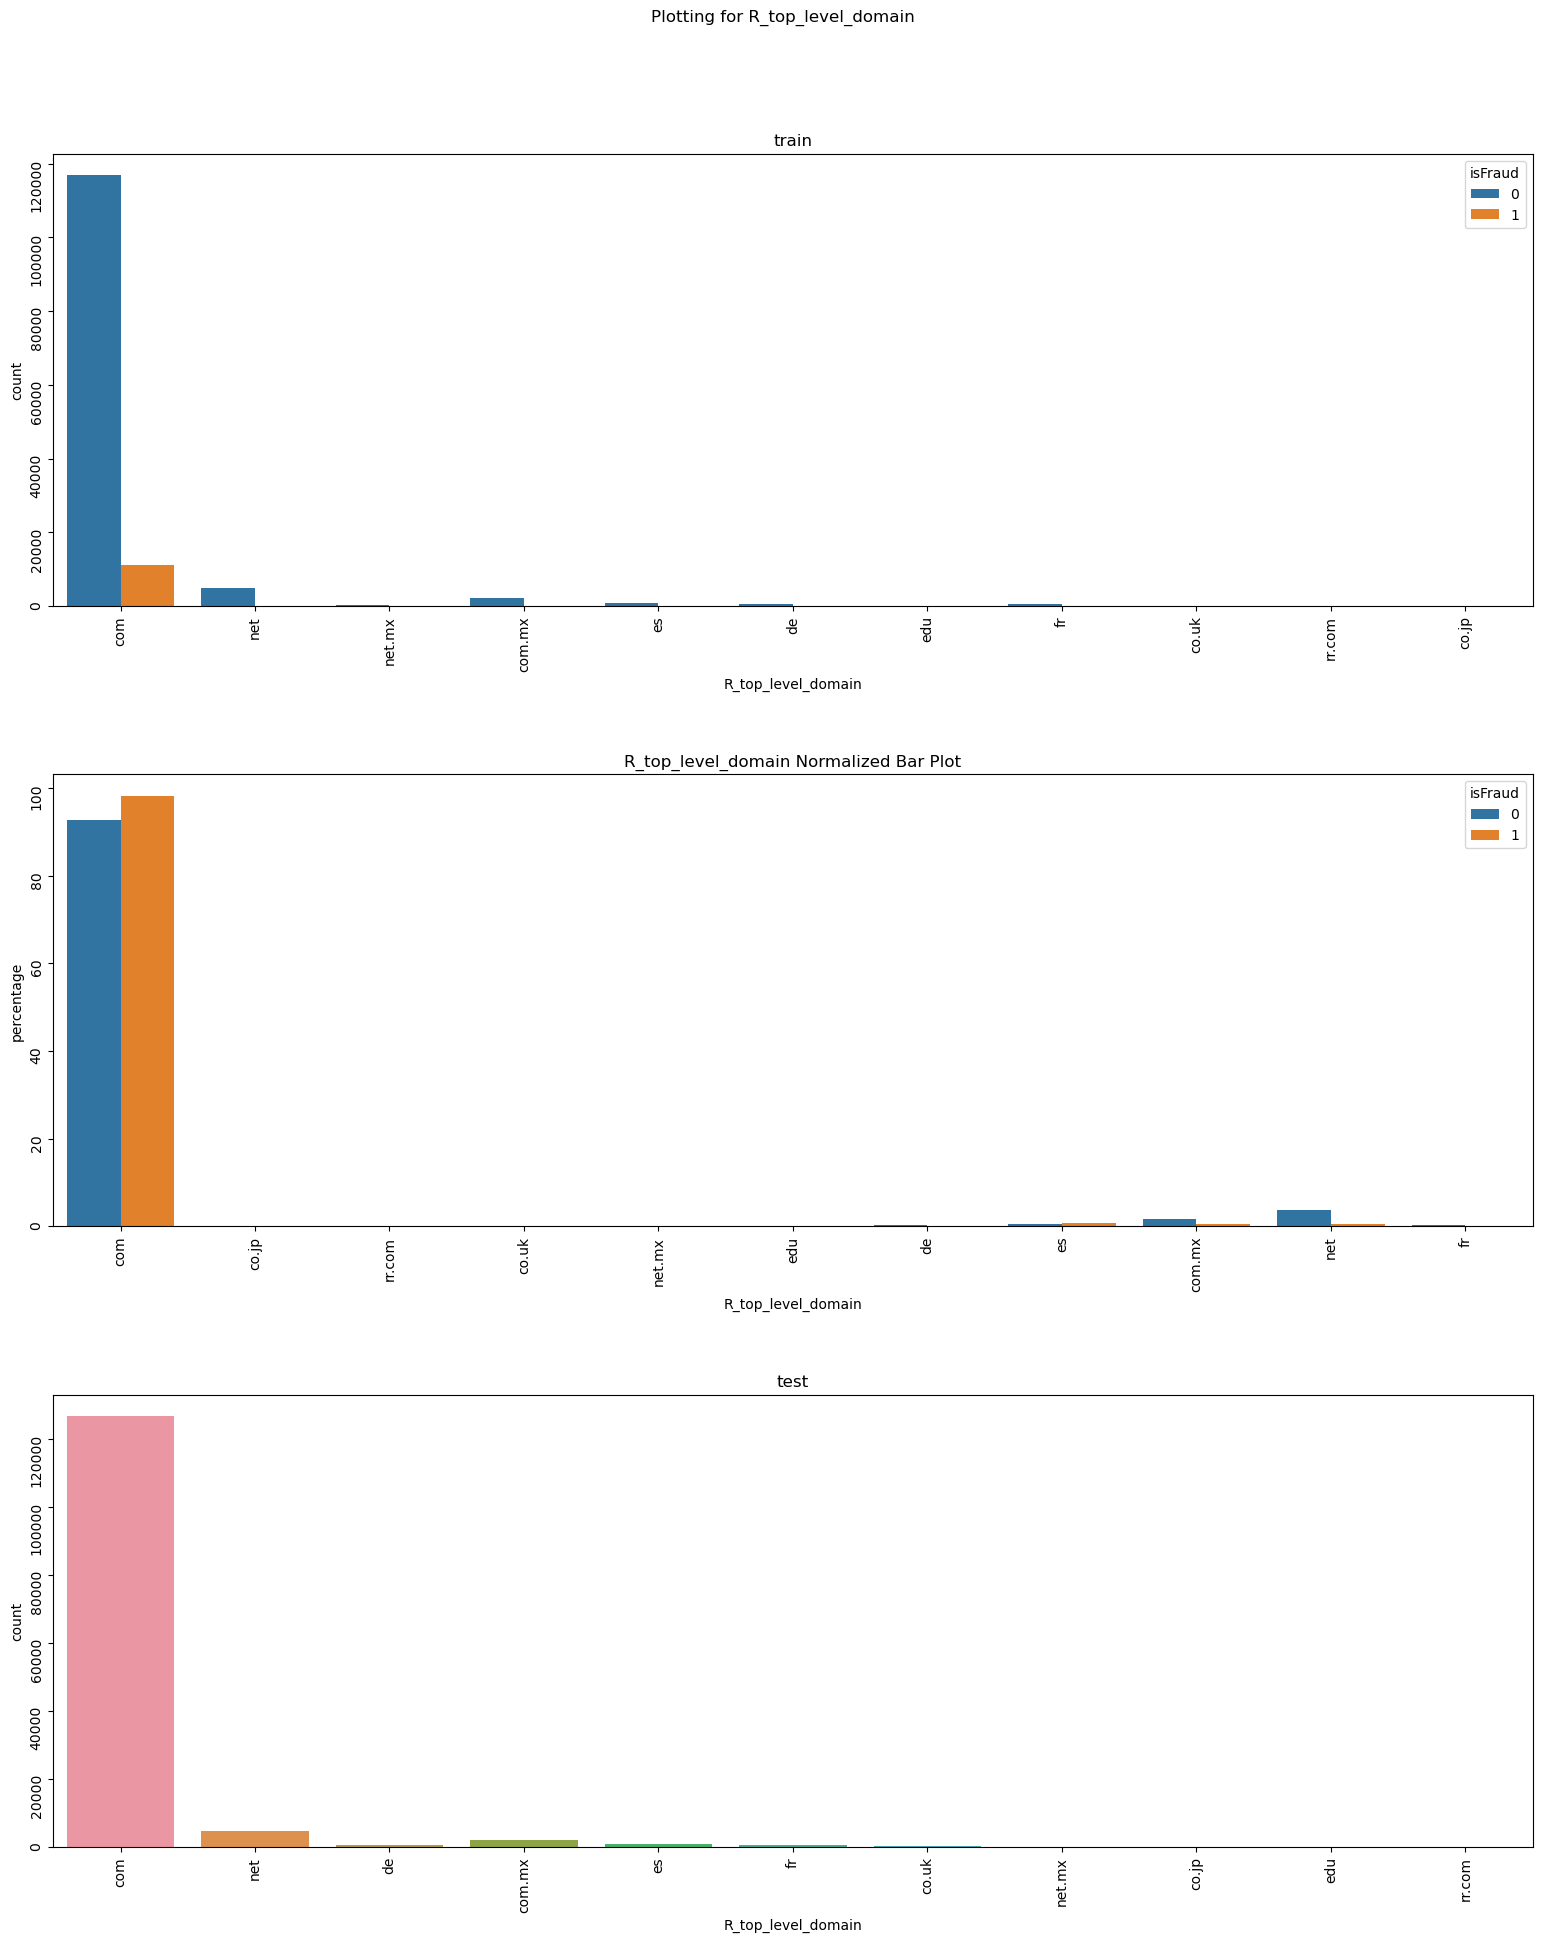

In [165]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_top_level_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='R_top_level_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("R_top_level_domain Normalized Bar Plot")
sns.barplot(x="R_top_level_domain", y="percentage", hue="isFraud", data=norm_R_top_level_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_top_level_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

## Device Type

In [167]:
# https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm?select=submission.csv

def parent_device_name(df):
  '''
    Utility Function to map deice name to its parent company.
  '''

  if(df['device_name'].isna().all()):
        return df
    
  df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
  df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
  df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
  df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
  df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
  df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
  df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
  df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
  df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"

  return df

In [168]:
train_data['device_name'] = [np.nan if pd.isna(v) else v.split('/')[0] for v in train_data['DeviceInfo'].values]
test_data['device_name'] = [np.nan if pd.isna(v) else v.split('/')[0] for v in test_data['DeviceInfo'].values]

train_data['device_version'] = [np.nan if (pd.isna(v)) or (len(v.split('/'))<=1) else v.split('/')[1] for v in train_data['DeviceInfo'].values]
test_data['device_version'] = [np.nan if (pd.isna(v)) or (len(v.split('/'))<=1) else v.split('/')[1] for v in test_data['DeviceInfo'].values]

train_data = parent_device_name(train_data)
test_data = parent_device_name(test_data)

In [169]:
norm_device_name = (train_data.groupby(['isFraud'])['device_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

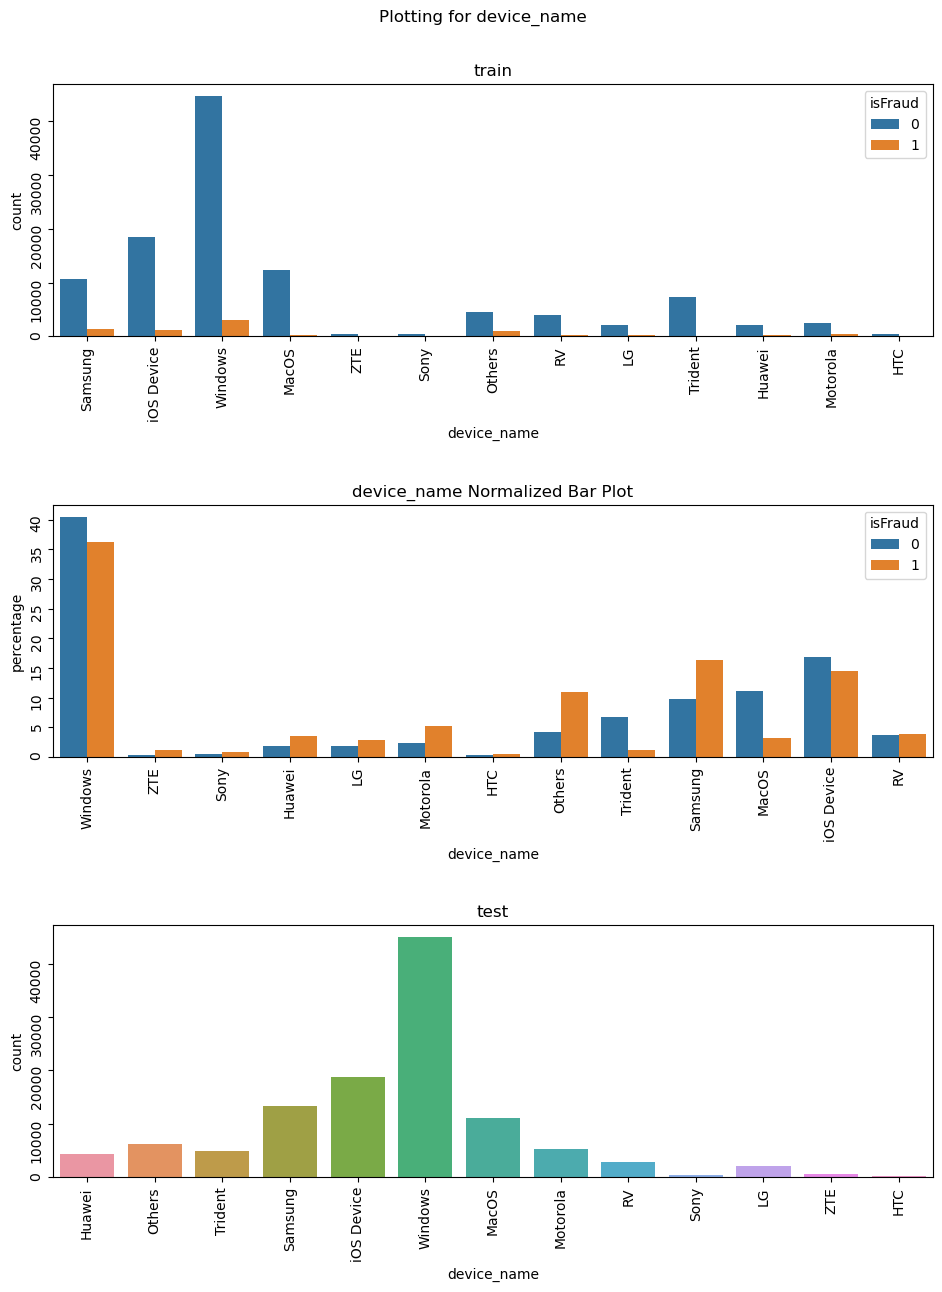

In [170]:
fig, ax = plt.subplots(3,1, figsize=(12,14))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for device_name", y=0.95)

ax[0].set_title('train')
sns.countplot(x='device_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("device_name Normalized Bar Plot")
sns.barplot(x="device_name", y="percentage", hue="isFraud", data=norm_device_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="device_name", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

In [171]:
norm_device_version = (train_data.groupby(['isFraud'])['device_version']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

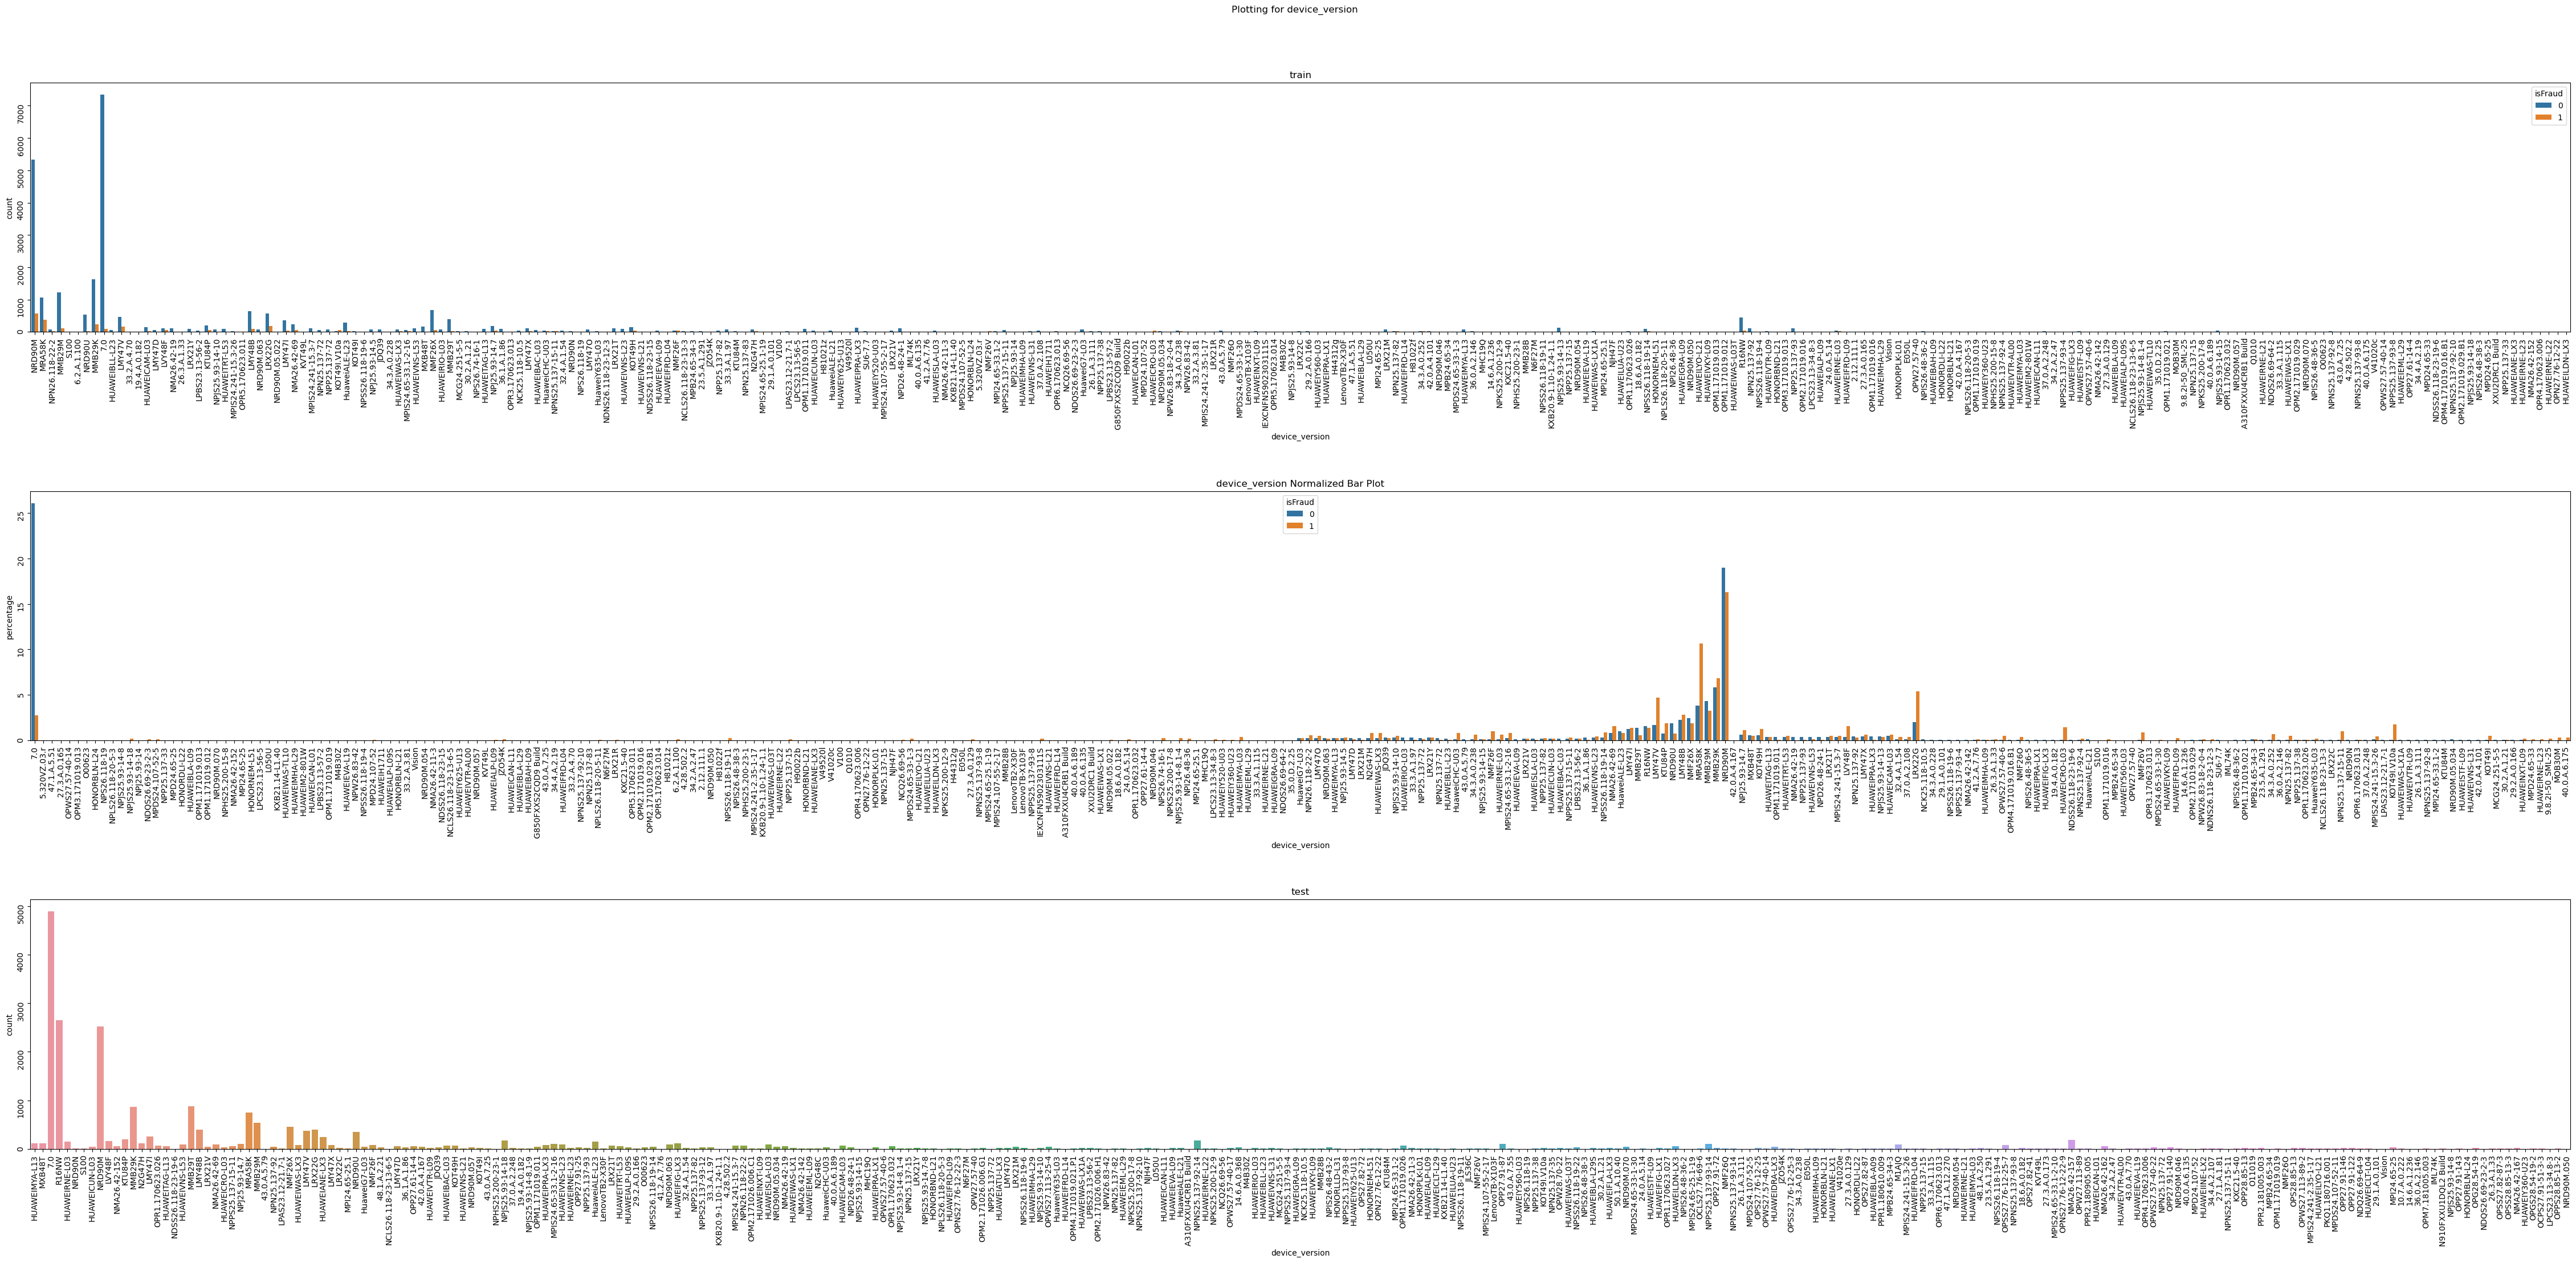

In [172]:
fig, ax = plt.subplots(3,1, figsize=(50,24))
fig.tight_layout(pad=18.0)
fig.suptitle("Plotting for device_version", y=0.95)

ax[0].set_title('train')
sns.countplot(x='device_version', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("device_version Normalized Bar Plot")
sns.barplot(x="device_version", y="percentage", hue="isFraud", data=norm_device_version, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="device_version", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

## OS Info

In [173]:
train_data['os_name'] = [info if (pd.isna(info)) or (len(info.split())<=1) else ' '.join(info.split()[:-1]) for info in train_data['id_30']]
test_data['os_name'] = [info if (pd.isna(info)) or (len(info.split())<=1) else ' '.join(info.split()[:-1]) for info in test_data['id_30']]

train_data['os_version'] = [np.nan if (pd.isna(info)) or (len(info.split())<=1) else info.split()[-1] for info in train_data['id_30']]
test_data['os_version'] = [np.nan if (pd.isna(info)) or (len(info.split())<=1) else info.split()[-1] for info in test_data['id_30']]

In [174]:
norm_os_name = (train_data.groupby(['isFraud'])['os_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

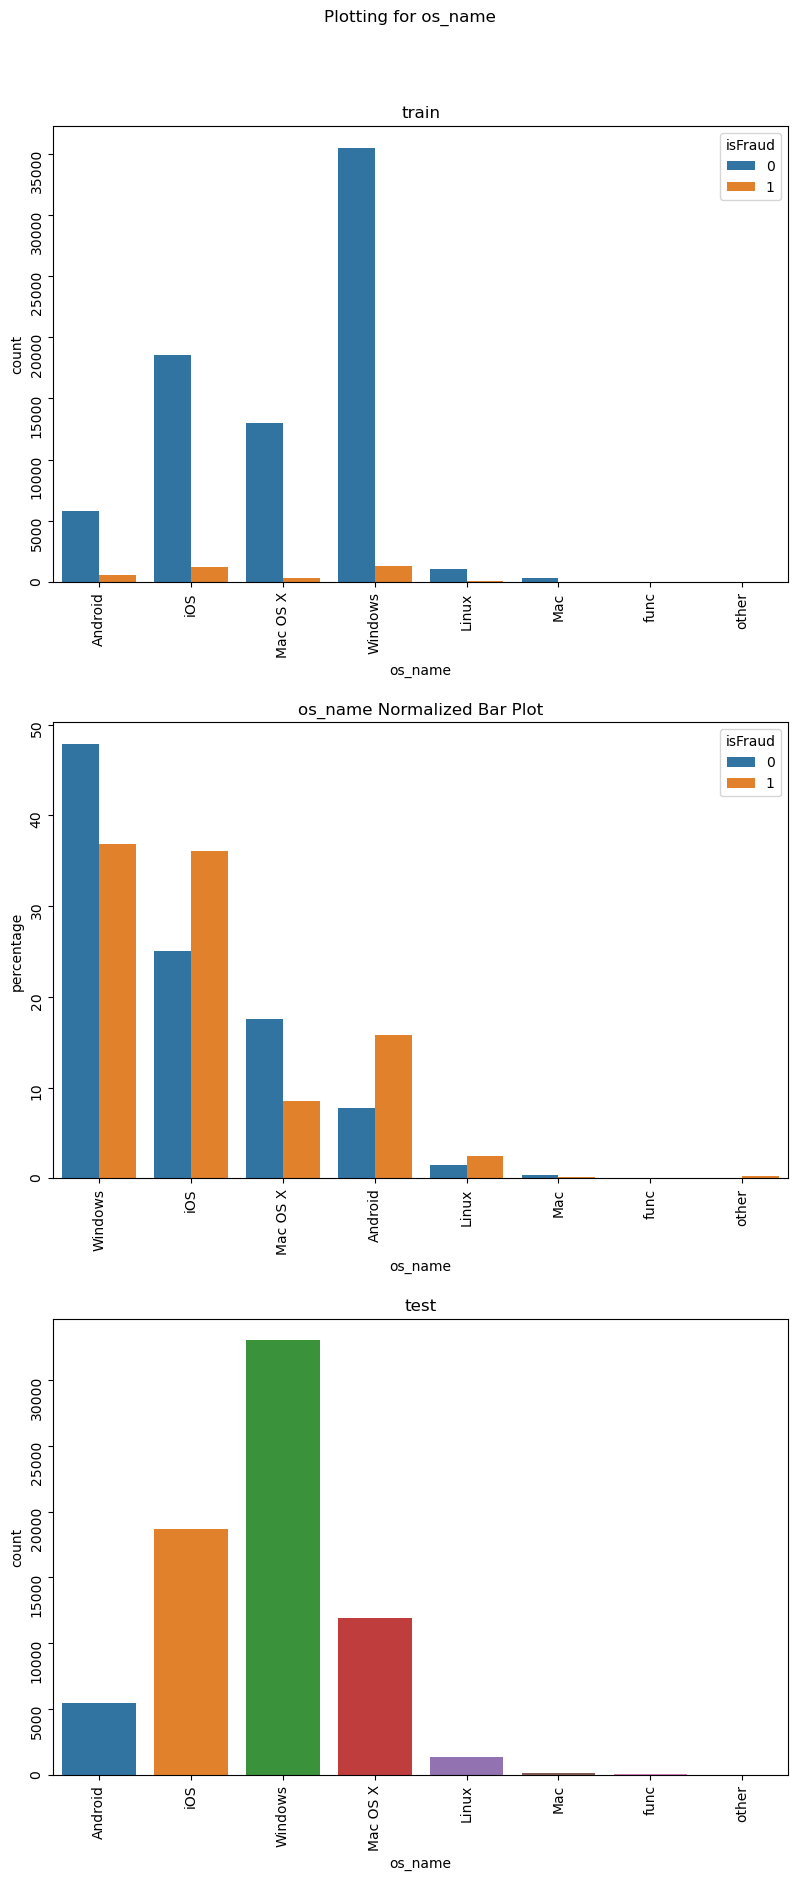

In [175]:
fig, ax = plt.subplots(3,1, figsize=(10,19))
fig.tight_layout(pad=8.0)
fig.suptitle("Plotting for os_name", y=1)

ax[0].set_title('train')
sns.countplot(x='os_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("os_name Normalized Bar Plot")
sns.barplot(x="os_name", y="percentage", hue="isFraud", data=norm_os_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="os_name", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()